# Juliaで強化学習Tutorial

ここではJuliaのコーディングを学びながら強化学習の問題設定・アルゴリズムについて学んで行くためのTutorialを書き記す。

教科書のおすすめは[強化学習(森村哲郎)(以下クジラ本と呼ぶ。)](https://www.amazon.co.jp/%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%83%95%E3%82%A7%E3%83%83%E3%82%B7%E3%83%A7%E3%83%8A%E3%83%AB%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E6%A3%AE%E6%9D%91-%E5%93%B2%E9%83%8E/dp/4065155916/ref=sr_1_1?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&crid=3SWHHJD58U62A&keywords=%E6%A3%AE%E6%9D%91%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92&qid=1703212182&sprefix=%E6%A3%AE%E6%9D%91+%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92%2Caps%2C242&sr=8-1)と[ゼロから作るデープラーニング4-強化学習-(斎藤興毅)](https://www.amazon.co.jp/%E3%82%BC%E3%83%AD%E3%81%8B%E3%82%89%E4%BD%9C%E3%82%8BDeep-Learning-%E2%80%95%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92%E7%B7%A8-%E6%96%8E%E8%97%A4-%E5%BA%B7%E6%AF%85/dp/4873119758/ref=sr_1_1?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&crid=3QBRFO7FQGHEO&keywords=%E3%82%BC%E3%83%AD%E3%81%8B%E3%82%89%E4%BD%9C%E3%82%8B%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92&qid=1703212249&sprefix=%E3%82%BC%E3%83%AD%E3%81%8B%E3%82%89%E4%BD%9C%E3%82%8B+%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92%2Caps%2C266&sr=8-1)である。理論的な部分は、森村さんのクジラ本が丁寧に書いてある。とはいえコード実装例とかは乏しいので、ゼロ作等で補完すると良いだろう。それより最近の話題については論文とそれに付属のソースコードを見る事を勧める。(上記２冊を読めば、そんなに困らずに読めるはず。)特にDeepMind様のソースコードは読みやすい気がするのでオススメ。

０章は導入のため、完全にお話になっていて、Juliaによるコーディングは１章の終盤から始まり、ニューラルネットを用いた強化学習のコーディングは２章から始まる。

## 0. 強化学習の問題設定

強化学習とは、環境(与えられるタスクと報酬体系)とエージェント(タスクをこなすための戦略(Policy)を持っている存在)からなる系である。
エージェントは環境の状態(の一部)を知ることが出来、環境に対して何かしらの行動を取ることで報酬を得ることが出来る。(問題によっては行動によって環境の状態を変化させることが出来る。)
「(エージェントが最初に環境の情報を知らない状態からスタートし、試行錯誤を繰り返すうちに)ある環境の中で目的関数(最終的に得られる報酬和など)を最大化するような戦略(一連の行動手順)を見つける」という問題を強化学習と呼ぶ。

ふんわりとした数式で一旦定義しておこう。

環境$\mathcal{E}$は
 $$ \mathcal{E} = \{\mathcal{A} , \mathcal{S}, p_T(s_{t+1}|\{s_t\},\{a_t\}) , r(\{a_t\},\{s_t\})\}, \\
  (\{s_t\} = \{s_0, s_1, \dots, s_t\}, \{a_t\} = \{a_1, \dots, a_t\}, s_t,s_{t+1}\in \mathcal{S}, a_t\in\mathcal{A} )$$
で書くことが出来る。$\mathcal{A}$はエージェントの取ることが出来る行動空間であり、$\mathcal{S}$は環境の取りうる状態空間, $p_T(s_{t+1}|\{s_t\},\{a_t\})$は状態$s_t$の時に行動$a_t$をとった時に次の遷移した状態が$s_{t+1}$である確率である。$r(a,s)$は状態sの時にエージェントが行動aを起こした時にエージェントに与えられる報酬である。これらが定義されているのが環境である。

一方で、エージェントとは(一般に確率的な行動指針)ポリシー$\pi$を持っていて、
 $$ p_a = \pi(a|\{\bar{s}_t\}, \{a_{t-1}\}) \ \ \ \ \sum_a p_a = 1$$
と書ける。エージェントの観測できる環境の状態(の一部)の時系列が$\{s_t\}$,自分の今までの行動が $\{a_{t-1}\}$の時に行動aを$p_a$の確率で取るという戦略になっている。エージェントも決定的な行動をとる場合は、$p_a$はone-hotベクトル(ある一つの要素が1でそれ以外が0)
一般には、エージェントの観測できる環境の状態は一部であり($\mathrm{dim}|\bar{s}| < \mathrm{dim}|s|$)、そのような問題は部分観測問題と呼ばれるが、今回は着目しない。

強化学習の問題とは、エージェントが$\pi$に従って行動を行なっていった際の何かしらの目的関数$f$の期待値$E_{\pi}[f]$を最大化するような最適な方策$\pi$を見つける問題である。


ここで例を考えてみよう。

コンビニにおやつを5回買いに行って１回当たり１個おやつを買うことが出来る。コンビニには見た事のない３種類のおやつがあり、最初味はわからないとする。5回の購入の総合満足度を最大化したい。

最初の購入は、情報が全くないのでランダムだが、例えばAのお菓子を買ったとし、それが不味く満足度-2としよう。

次の購入では多くの場合、別のお菓子を買ってみるだろう。ここでBのお菓子を買い、その満足度が+5だとする。
さてここで残り３回の購入でCを試すかどうかである。Cの満足度はBより高く+10かもしれないし、Aよりもひどく-10かもしれない。それだったらBを３回買って満足するのが良いのかもしれない。

強化学習の立場では、ここでCを買ってみる事を「探索」と呼び、Bを買い続ける事を「活用」と呼ぶ。より一般的には、「データをもっと集めるべきとし、新しい選択肢を選ぶ事」と「今あるデータを十分とし利用する事」である。今回の例は種類が少ないので全部試せば良いような気もするが、ここで種類が莫大に増えてきたりすると、問題は難しくなっていく。

この「探索」と「活用」をどのようなバランスで行なっていき最善戦略を見つけるかが強化学習の難しさである。

(注：既にデータを準備した状態で報酬を最大化するようにデータの中での最善方策を考える問題もある。)

## 0-1. 強化学習の分類

ここで、強化学習の問題についてそれぞれの設定による分類をしておこう。

環境側の分類として状態遷移確率と報酬関数がそれぞれマルコフ的である時($p_t(s_{t+1}|\{s_t\}, \{a_{t}\}) = p_t(s_{t+1}|s_t, a_t)$, $r(\{s_t\}, \{a_{t}\}) = r(s_t,a_t)$)、これをマルコフ決定過程(Markov Decision Process)と呼ぶ。

環境の$r, p_t$が既知の場合(つまり既に探索は終わっていて、活用のみをすれば良い時)、その問題をプランニング問題と呼ぶ。これは狭義の強化学習には含まれない。

次に$r, p_t$が未知の場合を考える。これが狭義の強化学習である。この場合はエージェントの方策によって分類をするべきであろう(未知のもので分類することに意味はないので)。
エージェントの方策が直前の状態のみに依存する場合($\pi(a_{t}|\{s_t\}, \{a_{t-1}\}) = \pi(a_t|s_t)$)、マルコフ方策問題と呼び、そうでない場合は、非マルコフ方策問題と呼ぶ。さらに方策が決定論的$\pi(a_t|) = \delta_{a_t, a^*}$な場合は、決定的方策、そうでない場合は確率的方策と呼ぶ。
この呼び方はプランニング問題にも適用できる。

また方策のアップデートの仕方について、データをそれなりに集めて方策をアップデートする場合はオフライン学習(バッチ学習)と呼ばれ、集めながら方策も同時に更新していくやり方をオンライン学習と呼ぶ。


また強化学習のエージェントの内部に、環境モデルを推定するアーキテクチャがあるかないかで、モデルベースド/モデルフリーの強化学習という分類もある。



以降では、マルコフ決定過程の問題について考えていく。


## 1. プランニング問題

まず環境について報酬関数$r(\{s_t\}, \{a_t\})$や状態遷移確率$p_t(s_{t+1}|\{a_t\},\{s_t\})$が既知であるとして、エージェントが最善方策をどのように導くかという問題について考える。ここでの内容は(環境が未知の場合の)狭義の強化学習にも応用できるので学んでおこう。



### 1-1. マルコフ方策の十分性(未完)
前節で方策についての分類を行ったが、基本的に非マルコフ方策は考えるべき次元が膨大になる($|\mathcal{A}\mathcal{S}|^t$)のであまり考えたくない。そこで、マルコフ決定過程においては、目的関数が以下の性質を満たせば、マルコフ方策を考えそれを最適化すれば十分である事を述べておく。(マルコフ決定過程ならマルコフ方策だけで十分なのは当たり前のように感じるかもしれないが、目的関数に非マルコフ性があれば事情は異なる。)

方策$\pi$に従って行動した際の時刻tでの(s,a)の周辺確率を$\phi_t^{\pi}(s,a|s_0)$とすると、目的関数Lが
$$
L(\{s_t\},\{a_t\}) = L(\phi^{\pi}_0,\dots, \phi^{\pi}_0)
$$
と書けるとき、マルコフ方策を考えれば十分である。(証明はクジラ本へ。すぐ追えます。)



### 1-2. 価値関数とベルマン方程式

前節で定義したリターン$C_{t_0} = \sum_{t=0}^{t_f} \gamma^t r_{t_0+t}$を目的関数とする場合を考えていく。すなわち
$$
f(\pi) = E_\pi[C_0|s_0]
$$
を最大化する方策$\pi$を見つけたい。ここで状態価値関数$V(s)$を以下で定義しておく。

$$
V^{\pi}(s) = E_{\pi}[C_0|s_0=s]
$$

と$f(\pi) = E_\pi[C_0|s_0] = V^{\pi}(s_0)$なので$V(s)$の最適化を考えれば良い。
ここで以下の式が成り立つ。

$$
\begin{aligned}
V^*(s_0) &= \mathrm{max}_{\pi} V^{\pi}(s_0) \\
    &= \mathrm{max}_{\pi} [E^{\pi} [C_0|s_0]] \\
    &= \mathrm{max}_{\pi} [E^{\pi} [(r(s_0, a_0) + \gamma C_1)|s_0]] \\
    &= \mathrm{max}_{\pi} [\sum_{a_0} \pi(a_0|s_0)\{r(s_0, a_0) + \gamma \sum_{s_1}p_t(s_1|s_0, a_0) V^{\pi}(s_1)\}] \\
    &= \mathrm{max}_{a_0} [\{r(s_0, a_0) + \gamma \sum_{s_1}p_t(s_1|s_0, a_0) V^{*}(s_1)\}]
\end{aligned}
$$

上式は$V^{\pi}(s)$についての再帰的な方程式になっており、関数についての作用素(ベルマン作用素)$B_*$を用いて、$V^* = B_*V^*$と書ける。これをベルマン方程式と呼ぶ。

また$V^{\pi}(s)$自体にも、以下のベルマン方程式が成り立つ。($V^\pi = B_\pi V^\pi$)
$$
V^{\pi}(s_0) =  \sum_{a_0} \left[\pi(a_0|s_0)\left\{r(s_0, a_0) + \gamma \sum_{s_1}p_t(s_1|s_0, a_0) V^{\pi}(s_1)\right\}\right] 
$$

### 1-3. (余談)ベルマン方程式と最小作用の原理

状態価値関数についてのベルマン方程式なるものが登場したわけだが我々物理学徒はこれに似たものを知っている。最小作用の原理である。

ラグランジュ形式において、作用は以下の形で書ける。
$$
 S[x|x_0,t_0] = \int_{t_0}^{t_f} dt L(x,\dot{x},t) \simeq L(x_0, \dot{x}, t_0)\delta t + S[x|x_0+\dot{x}_0\delta t,  t_0+\delta t]
$$
これをxについて最小化するような条件からオイラー・ラグランジュ方程式(運動方程式)が出てくるわけである。(つまり$\mathrm{min}_xS[x]$を解きたい)

ここで前章で出てきたベルマン方程式と見比べてみると、
$$
V^*(s_0) = \mathrm{max}_{\pi}V^{\pi}(s_0) \Rightarrow \mathrm{min}_{\{x_t\}}S[x|x_0, t_0],\\
r(s_0,a_0) \Rightarrow L(x,\dot{x}, t_0)\delta t,\\
p_t(s_1|s_0, a_0) = \delta(x_1 - (x_0 + \dot{x_0}\delta t)),\\
\gamma=1
$$
とすれば、対応することがわかる。

逆に言えば、ベルマン方程式はラグランジュ形式の作用を少し一般化して$\tilde{L}(x,\dot{x}, t) = e^{-\gamma t}L(x,\dot{x}, t)$として確率過程の作用(ラグランジアン)を考えている事になる。$0<\gamma<1$の場合は、何かしらの散逸項が付いている場合の確率過程の作用と考えれば良いだろう。

という事は、同様にベルマン方程式の停留条件からオイラー・ラグランジュ方程式の導出も出来る。ベルマン方程式において、エージェントは速度を決定する行動を取れるとすると(つまり、$a_t = \dot{s}_t$とすると、)、ベルマン方程式は、
$$
\begin{aligned}
V^{*}(s_0) &= \mathrm{max}_{a_0} [\{r(s_0, a_0) + \gamma \sum_{s_1}p_t(s_1|s_0, a_0) V^{*}(s_1)\}] \\
    &= \mathrm{max}_{a_0} \left[\left\{L(s_0, a_0)\delta t + \gamma \left(V^{*}(s_0) + \frac{\partial V^*}{\partial s} a_0 \delta t\right)\right\}\right] \\
\Rightarrow (1-\gamma)V^{*}(s_0) &= \mathrm{max}_{a_0} \left[L(s_0, a_0) + \gamma \left(\frac{\partial V^*}{\partial s}\right) a_0\right]\delta t\\
\\
\Rightarrow &\frac{\partial L}{\partial a} + \int dt \gamma^{t+1}\left(\frac{\partial L}{\partial s}\right) = 0\\
\Rightarrow &\frac{d}{\gamma dt}\left(\frac{\partial L}{\partial a}\right) +  \gamma^{t}\left(\frac{\partial L}{\partial s}\right) = \frac{d}{\gamma dt}\left(\frac{\partial L}{\partial \dot{s}}\right) + \gamma^{t} \left(\frac{\partial L}{\partial s}\right) = 0
\end{aligned}
$$

４行目の導出が停留条件であり、５行目が($\gamma=1$で)オイラー・ラグランジュ方程式である。($\gamma=1-\eta$として$\gamma^t \simeq e^{-\eta t}$とすれば、散逸ありの運動方程式)
よって、ベルマン方程式を解く事は、強化学習における状態の軌跡(運動方程式)を解く事に他ならない。



### 1-4. (価値観数についての)ベルマン作用素の縮小性と解の一意性

さて前節で、ベルマン方程式と最小作用の原理の対応についてみた際に、「$\gamma=1$で良いのでは？」と思ってしまった方も居るかもしれない。しかしγを１以下にしておく事でベルマン作用素の縮小性と解の一意性と保証することが出来、それにより次の章で行うような動的計画法による解法を用いることが出来る。

$v_0(s)= V^\pi(s) + d(s)$とすると、
$$
\begin{aligned}
v'(s) = B_\pi v(s) &= \sum_{a} \left[\pi(a|s)\left\{g(s, a) + \gamma \sum_{s'}p_t(s'|s, a) v_0(s')\right\}\right] \\
    \Rightarrow v'(s)-V^\pi(s) &= \gamma\sum_{a, s'}\pi(a|s)p_t(s'|s, a) \left(v_0(s')-V^{\pi}(s')\right)\\
    \Rightarrow |d'(s)| &\leq \gamma\sum_{a, s'}\pi(a|s)p_t(s'|s, a) |v_0(s')-V^{\pi}(s')|\\
    &\leq \gamma \mathrm{max}_{s'}|d(s')|\\
    \Rightarrow \mathrm{max}_{s}|B_\pi d(s)| &\leq \gamma \mathrm{max}_{s}|d(s)|
\end{aligned}
$$

が成立するため、($0<\gamma<1$ならば)ベルマン作用素$B_\pi$を作用させる度に、ベルマン作用素の固有関数(すなわち真の価値関数)との差は縮小していく。これは$B_*$についても同様に証明が出来る。またこの縮小性から、解の一意性も証明することが出来る。

### 1-5. 動的計画法

$V^*(s)$が分かれば、最善方策$\pi_*(a|s)$はベルマン方程式を用いて、
$$
\pi_*(a|s) = \delta_{a,a^*},\\
a^* = \mathrm{argmax}_a \left[r(s,a) + \gamma \sum_{s'} p_T(s'|s,a)V^*(s')\right] 
$$
で与えられる。

前節において価値関数についてのベルマン方程式の縮小性と解の一意性があることがわかった。よって適当な価値関数からスタートして、最適価値関数についてのベルマン作用素を作用させ続ければ、真の最適価値関数に収束し、そこから最善方策を導くことが出来る。これを価値反復法と呼ぶ。

### 1-5-1. 価値反復法の実装
ようやくJulia Partである。実装してみよう。以下のようなゲームを考える。手札を消費して得点を得るカードゲームのようなものを考える。手札を２枚消費する事でその時持っていた枚数に応じて得点を得られる。４枚消費で大量得点をする事も出来る。手札がの時は、ポイントを消費して、手札消費の代わりに手札入れ替えが出来る。またポイントを支払う事で、手札を補充する事も出来る。手札の最大枚数は５枚とし、初期手札枚数は1,3,5から始まるとする。

上記のゲームは以下のような図で表される。(茶色の行動(チャージとフルバースト)を1,緑の行動(バーストとパス)を2とする。)
これをベルマン作用素を繰り返し作用させる、価値反復法で解いてみよう。
<img src="game_image.png">

In [1]:
using LinearAlgebra

In [2]:
#環境の定義
struct Env_duel
    s_dim::Int
    a_dim::Int
    g::Matrix{Float32} #報酬関数 reward matrix[action, state]
    pt::Array{Float32, 3} #状態遷移確率 transion function [action, state, next state]
end

function init_envd()
    s_dim::Int = 3
    a_dim::Int = 2
    g = Float32[-6 -2 10; -2 2 5]
    pt = zeros(Float32, a_dim, s_dim, s_dim)
    pt[1, :, :] = [0.0f0 1.0f0 0.0f0; 0.0f0 0.0f0 1.0f0; 1.0f0 0.0f0 0.0f0]
    pt[2, :, :] = [1.0f0 0.0f0 0.0f0; 1.0f0 0.0f0 0.0f0; 0.0f0 1.0f0 0.0f0]
    
    return Env_duel(s_dim, a_dim, g, pt)
end

init_envd (generic function with 1 method)

In [3]:
# エージェント(プレイヤー)の定義
mutable struct Duelist
    policy::Matrix{Float32} #方策[a|s]
    γ::Float32 #割引率
    valuefn::Vector{Float32} #価値関数[s]
end

function init_agt(en::Env_duel,γ::Float32)
    policy = zeros(Float32, en.a_dim, en.s_dim)
    policy[2,:] = ones(Float32, en.s_dim)
    valuefn = zeros(Float32, en.s_dim)
    return Duelist(policy, γ, valuefn)
end

init_agt (generic function with 1 method)

In [4]:
#ベルマン作用素を作用させ、価値関数をアップデート
function value_update!(en::Env_duel, ag::Duelist)
    old_vfn = ag.valuefn
    for s in 1:en.s_dim
        ag.valuefn[s] = maximum(en.g[:,s] + ag.γ*en.pt[:,s,:]*old_vfn)
    end
end

value_update! (generic function with 1 method)

In [5]:
#価値関数から決定的方策を導出
function best_policy!(en::Env_duel, ag::Duelist)
    for s in 1:en.s_dim
        best_action = argmax(en.g[:,s] + ag.γ*en.pt[:,s,:]*ag.valuefn)
        ag.policy[:,s] = zeros(Float32, en.a_dim)
        ag.policy[best_action,s] = 1.0f0
    end
end

best_policy! (generic function with 1 method)

In [6]:
en = init_envd()
ag = init_agt(en, 0.98f0)
n_itr = 100
vs = zeros(Float32, n_itr, en.s_dim)
pols = zeros(Int, n_itr, en.s_dim)
for itr in 1:n_itr
    value_update!(en, ag)
    vs[itr,:] = ag.valuefn
    best_policy!(en, ag)
    pols[itr, :] = [argmax(ag.policy[:,s]) for s in 1:en.s_dim]
end
println(ag.valuefn)
best_policy!(en, ag)
println(ag.policy)

Float32[64.457214, 71.948074, 75.50912]
Float32[1.0 1.0 0.0; 0.0 0.0 1.0]


In [18]:
using Plots

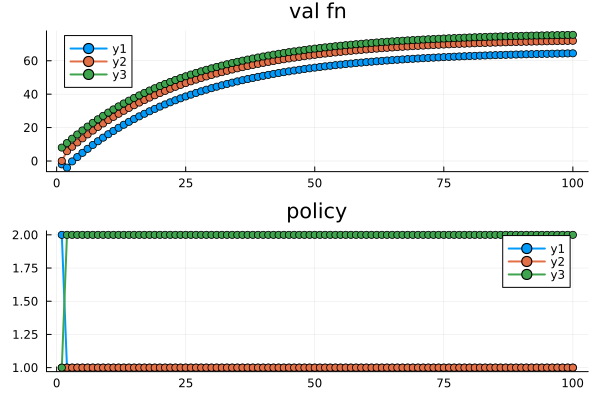

In [25]:
p1 =plot(vs, lw = 2.0, marker=:circle, title="val fn")
p2 = plot(pols, lw = 2.0, marker=:circle, title="policy")
plot(p1, p2, layout=(2,1))

$\gamma$が小さい方が収束自体は早い

Float32[5.8420954, 13.157885, 16.842094]
Float32[1.0 1.0 0.0; 0.0 0.0 1.0]


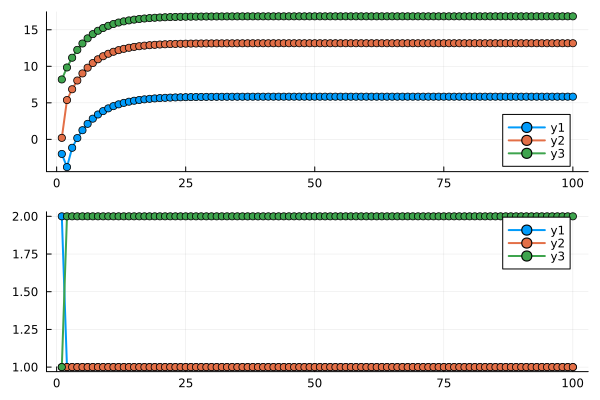

In [26]:
ag = init_agt(en, 0.9f0)
n_itr = 100
vs = zeros(Float32, n_itr, en.s_dim)
pols = zeros(Int, n_itr, en.s_dim)
for itr in 1:n_itr
    value_update!(en, ag)
    vs[itr,:] = ag.valuefn
    best_policy!(en, ag)
    pols[itr, :] = [argmax(ag.policy[:,s]) for s in 1:en.s_dim]
end
println(ag.valuefn)
best_policy!(en, ag)
println(ag.policy)
p1 =plot(vs, lw = 2.0, marker=:circle)
p2 = plot(pols, lw = 2.0, marker=:circle)
plot(p1, p2, layout=(2,1))

一方で小さすぎると、未来の報酬が見えず、間違った方策を作るようになる(悪い価値関数の定義になってしまう)。下は$\gamma=0.5$にした場合の例。最善方策の収束先が違っている。

実際の計算では一般に$\gamma$をどれくらいにするのが適切かわからないので、経験的に$0.95\sim 0.99$くらいにする事が多い。(僕の経験ではなく、多くの論文の設定として)

Float32[-4.0, 2.0, 8.0]
Float32[0.0 1.0 1.0; 1.0 0.0 0.0]


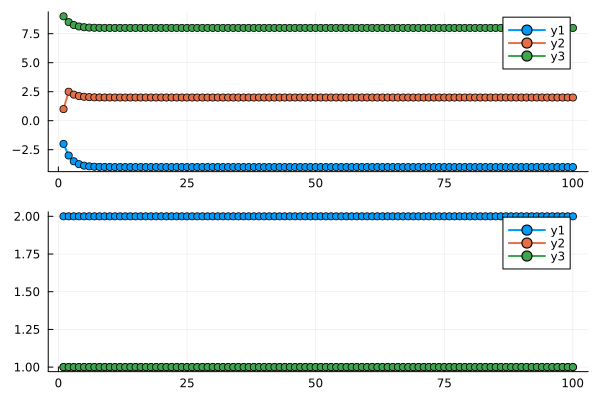

In [27]:
ag = init_agt(en, 0.5f0)
n_itr = 100
vs = zeros(Float32, n_itr, en.s_dim)
pols = zeros(Int, n_itr, en.s_dim)
for itr in 1:n_itr
    value_update!(en, ag)
    vs[itr,:] = ag.valuefn
    best_policy!(en, ag)
    pols[itr, :] = [argmax(ag.policy[:,s]) for s in 1:en.s_dim]
end
println(ag.valuefn)
best_policy!(en, ag)
println(ag.policy)
p1 =plot(vs, lw = 2.0, marker=:circle)
p2 = plot(pols, lw = 2.0, marker=:circle)
plot(p1, p2, layout=(2,1))

次に方策反復法も知っておこう。方策反復法は、「ある方策の下での価値関数を最大化し、その後方策を価値関数に基づいてアップデートする事を繰り返す方法」である。

In [28]:
#ベルマン作用素を作用させ、価値関数をアップデート
function value_update_pi!(en::Env_duel, ag::Duelist)
    old_vfn = ag.valuefn
    for s in 1:en.s_dim
        #ここの更新の仕方が最適価値関数(のベルマン作用素)の場合と異なる。
        ag.valuefn[s] =  ag.policy[:,s]'*(en.g[:,s] + ag.γ*en.pt[:,s,:]*old_vfn)
    end
end

value_update_pi! (generic function with 1 method)

Float32[5.8420954, 13.157885, 16.842094]
Float32[1.0 1.0 0.0; 0.0 0.0 1.0]


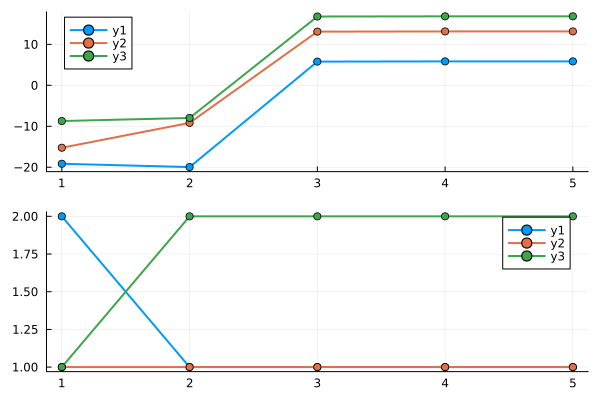

In [29]:
ag = init_agt(en, 0.9f0)
n_itr = 30
pu = 5
vs = zeros(Float32, pu, en.s_dim)
pols = zeros(Int, pu, en.s_dim)
for i in 1:pu
    for itr in 1:n_itr
        value_update_pi!(en, ag)
    end
    vs[i,:] = ag.valuefn
    best_policy!(en, ag)
    pols[i,:] = [argmax(ag.policy[:,s]) for s in 1:en.s_dim]
end
println(ag.valuefn)
best_policy!(en, ag)
println(ag.policy)
p1 =plot(vs, lw = 2.0, marker=:circle)
p2 = plot(pols, lw = 2.0, marker=:circle)
plot(p1, p2, layout=(2,1))

ここでは愚直にやったが、value_update_pi!の部分をitrを回さずに解析的に(逆行列計算して)一発で$V^{\pi}(s)$を計算する方法があるので、方策反復法の方が速かったりもする。(その場合上記のように3回方策更新するだけで最善方策にたどりつく)(詳しくは森村さんのクジラ本を見よう！)

### 2. 強化学習

さてようやく狭義の強化学習に取り掛かろう！狭義の強化学習においては、環境の持っている報酬関数$g(s,a)$と状態遷移確率$p_t(s'|s,a)$をエージェントは知らないので、ベルマン作用素がわからない状態である。そこで探索して情報を集め、その近似的な(標本近似した)ベルマン作用素を作り最適方策を導いていく事になる。

前章で述べたように、(最適)ベルマン方程式を解く事は、最小作用の原理(作用から解く)ことと同じなので、ベルマン作用素の標本近似は、ある種作用や分配関数のモンテカルロサンプリングに相当するものであると考えれば良いだろう。

まず後の便利のために、行動価値関数Qを定義・導入する。言葉通り、状態sにおいて行動aを取る価値であり、
$$
V^{\pi}(s) = \sum_a \pi(a|s) Q(s,a)\\
Q^{\pi}(s,a) = g(s,a) + \gamma\sum_{s'}p_t(s'|s,a)V^{\pi}(s')
$$
これはある種、環境の状態遷移確率を価値関数に取り込んだ関数になっている。
価値関数についてのベルマン方程式と同様にして、行動価値関数についてもベルマン方程式を書く事が出来、
$$
Q^{\pi}(s,a) = g(s,a) + \gamma\sum_{s', a'} p_t(s'|s,a) \pi(a'|s') Q(s', a') \\
\Rightarrow Q^{\pi} = B_Q Q^{\pi}
$$
となる。同様にして、最適価値関数に関するベルマン方程式は、
$$
Q^{*}(s,a) = g(s,a) + \gamma\mathrm{max}_a'\sum_{s', a'} p_t(s'|s,a) Q^*(s', a') \\
\Rightarrow Q^{*} = B_{Q*} Q^{*}
$$
1-4節で示したのと同様にして、$B_Q, B_{Q*}$についても縮小性と解の一意性が言える。

### 2-1. 行動価値関数についてのベルマン作用素の標本近似の収束性

収束性の証明はあるのだが、実際に使われるアルゴリズムでは証明で使われる仮定(エルゴード性やロビンスモンロー条件)が成り立っていないことが多い(収束が保証されていないが収束を早くするためにそのようにする事が多い)ので、ここでは割愛する。興味のある方はクジラ本を読むと良いだろう。

### 2-2. $\epsilon$-greedy法

さて今は狭義の強化学習について考えているので、探索行動を取るための指針が必要である。
ここでは探索行動はランダムとする$\epsilon$-greedy法について見ていこう。

もしも正しい行動価値関数$Q(s,a)$が分かっているとすると、
$$
\pi(a|s) = \delta_{a,a^*} \ (a^* = \mathrm{argmax}_a Q(s,a))
$$
で行動するのが最善方策である。一方で正しいQを得るためには、探索行動をして、(例えば$g(s,a)$などを実際に経験して)Qをアップデートしなければならない。
基本的には自身の持っている情報から最善行動をしなければ最適行動価値関数$Q^{*}$はベルマン方程式から求められないが、新しい情報を得るためには、それ以外の行動も試す必要がある。

そこで、最善と思っている行動以外を試す事をある確率でランダムに行う手法が$\epsilon$-greedy法である。
現状得られいる行動価値関数から
$$
\pi(a|s) = \begin{cases}
    1-\epsilon & (a = a^* = \mathrm{argmax}_a Q(s,a))\\
    \epsilon/(|A|-1) & (a \neq a^*)
    \end{cases}
$$
として方策$\pi$を定める。これにより方策を実行しながら、新たに得られた情報$g(s,a)$と次の状態$s'$を元に、
$$
\begin{aligned}
Q_{new}(s,a) &= (1-\alpha) Q_{old}(s,a) + \alpha \left[g(s,a) + \gamma\mathrm{max}_{a'}[Q_{old}(s',a')]\right]\\
&= Q_{old}(s,a) + \alpha \left[g(s,a) + \gamma\mathrm{max}_{a'}[Q_{old}(s',a')] - Q_{old}(s,a)\right]
\end{aligned}
$$
として、更新率$\alpha$でベルマン方程式を用いて更新していく。

学習率αについては、ロビンス・モンローの条件なるものが知られており、
$$
\sum_t \alpha_t = \infty, \ \ \sum_t \alpha_t^2 < \infty
$$
であれば、(無限の時間で)真の行動価値関数に収束する事が知られている。(今回は無限時間収集しないのでαを一定にしているが、最初大きめでだんだん小さくしていく場合もある。その時には、ロビンスモンロー条件に気をつけるのが良いだろう。)

さて、$\epsilon$-greedy法を実装してみよう！上でのカードゲーム環境において、最初プレイヤーは報酬関数$g(s,a)$を知らず、自分が実際に体験した報酬をその瞬間(行動価値関数, 方策をアップデートする瞬間)だけ覚えているものとする。

In [30]:
mutable struct greedyDuelist
    ϵ::Float32 #ε-greedyのε
    γ::Float32 #割引率
    α::Float32 #学習率
    ac_valuefn::Matrix{Float32} #価値関数[a|s]
end

In [5]:
using StatsBase

In [32]:
function decide_action(ag::greedyDuelist, s::Int)
    a_dim = size(ag.ac_valuefn)[1]

    #素直な実装
    w = ag.ϵ/(a_dim-1)*ones(Float32, a_dim)
    w[argmax(ag.ac_valuefn[:,s])] = 1.0f0 - ag.ϵ
    pw = ProbabilityWeights(w)
    return sample(1:a_dim, pw)
    #=
    #こっちのコードの方が簡潔
    if rand() < ag.ϵ
        return rand(1:a)
    else
        return argmax(ag.ac_valuefn[:,s])
    end=#
end

decide_action (generic function with 1 method)

In [33]:
function init_greedyd(en::Env_duel ,ϵ::Float32, γ::Float32, α::Float32)
    ac_valuefn = zeros(Float32, en.a_dim, en.s_dim)
    return greedyDuelist(ϵ, γ, α, ac_valuefn)
end

init_greedyd (generic function with 1 method)

In [34]:
function init_greedyd_opt(en::Env_duel, init::Float32 ,ϵ::Float32, γ::Float32, α::Float32)
    ac_valuefn = init*ones(Float32, en.a_dim, en.s_dim)
    return greedyDuelist(ϵ, γ, α, ac_valuefn)
end

init_greedyd_opt (generic function with 1 method)

In [35]:
function update_Q!(ag::greedyDuelist, s::Int, a::Int, r::Float32, s_next::Int)
    ag.ac_valuefn[a,s] += ag.α*(r + ag.γ*maximum(ag.ac_valuefn[:,s_next]) - ag.ac_valuefn[a,s])
end

update_Q! (generic function with 1 method)

In [36]:
function final_policy(ag::greedyDuelist)
    a_dim = size(ag.ac_valuefn)[1]
    s_dim = size(ag.ac_valuefn)[2]
    policy = zeros(Float32, a_dim, s_dim)
    for s in 1:s_dim
        best_action = argmax(ag.ac_valuefn[:,s])
        policy[:,s] = zeros(Float32, a_dim)
        policy[best_action,s] = 1.0f0
    end
    return policy
end

final_policy (generic function with 1 method)

Float32[4.7103157 11.431578 14.318185; 0.5748462 4.533002 13.350444]
Float32[1.0 1.0 1.0; 0.0 0.0 0.0]


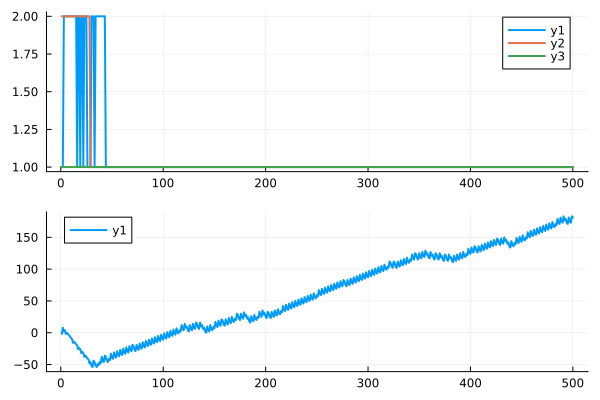

In [37]:
ag = init_greedyd(en, 0.1f0, 0.95f0, 0.2f0)
init_state = 2
n_itr = 500
acval_itr = zeros(Float32, n_itr, en.a_dim, en.s_dim)
pol_itr = zeros(Int, en.s_dim, n_itr)
rew_hist = zeros(Float32, n_itr)
now_state = init_state
tot_rew = 0.0f0
for trial in 1:n_itr
    a = decide_action(ag, now_state)
    next_state = sample(1:en.s_dim, ProbabilityWeights(en.pt[a,now_state,:]))
    update_Q!(ag, now_state, a, en.g[a,now_state], next_state)
    for s in 1:en.s_dim
        pol_itr[s, trial] = argmax(ag.ac_valuefn[:,s])
    end
    tot_rew += en.g[a, now_state]
    rew_hist[trial] = tot_rew
    now_state = next_state
end
println(ag.ac_valuefn)
println(final_policy(ag))
p1 = plot(pol_itr', lw=2.0)
p2 = plot(rew_hist, lw=2.0)
plot(p1, p2, layout=(2,1))

経験論的なものとして、行動価値関数$Q$の初期値をある程度高めの値で初期化しておく("楽観的な"初期化をする)事で、最善方策の発見を早くできる事が知られている。これの初期値が高い場合と低い場合を見てみよう。(確率的に探索するので、何回か実行してみて、収束の速さを見てみる事を進める。)($\epsilon=0.2$だとランダムの確率が高いのであまり違いは見えないが、$\epsilon=0.1$くらいにすると違いが見えたりする。)

理屈としては、「初期化の値が低いと、最初に試した行動よりも他の行動の評価値が低いので、最初に試した行動のみを繰り返してしまい、結果として探索がほとんど進まず最善方策を見つけるのが遅れ、長期的に見てもトータルの報酬が低くなってしまう」というったメカニズムである。(知見としては、「あんまり自分の経験のないものを見下さず(低めの評価をつけず)、一旦試してみる方が長期的には良かったりする」的な経験論だったりする。)

Float32[10.117075 19.369167 17.472305; 4.2668543 8.629515 22.90601]
Float32[1.0 1.0 0.0; 0.0 0.0 1.0]


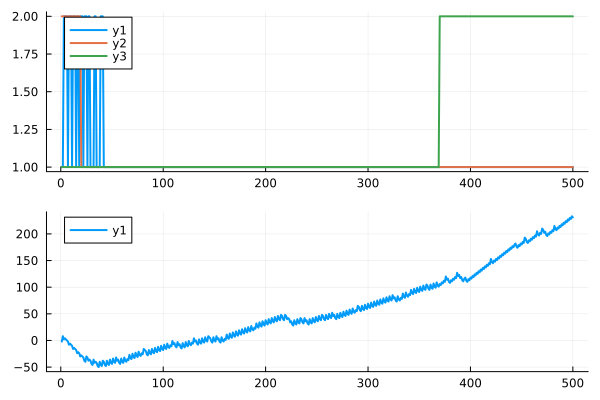

In [38]:
ag = init_greedyd_opt(en, 10.0f0, 0.1f0, 0.95f0, 0.2f0)
init_state = 2
n_itr = 500
acval_itr = zeros(Float32, n_itr, en.a_dim, en.s_dim)
pol_itr = zeros(Int, en.s_dim, n_itr)
rew_hist = zeros(Float32, n_itr)
now_state = init_state
tot_rew = 0.0f0
for trial in 1:n_itr
    a = decide_action(ag, now_state)
    next_state = sample(1:en.s_dim, ProbabilityWeights(en.pt[a,now_state,:]))
    update_Q!(ag, now_state, a, en.g[a,now_state], next_state)
    for s in 1:en.s_dim
        pol_itr[s, trial] = argmax(ag.ac_valuefn[:,s])
    end
    tot_rew += en.g[a, now_state]
    rew_hist[trial] = tot_rew
    now_state = next_state
end
println(ag.ac_valuefn)
println(final_policy(ag))
p1 = plot(pol_itr', lw=2.0)
p2 = plot(rew_hist, lw=2.0)
plot(p1, p2, layout=(2,1))

Float32[2.4602199 9.208552 12.045562; -3.1655934 -0.7708653 4.7500916]
Float32[1.0 1.0 1.0; 0.0 0.0 0.0]


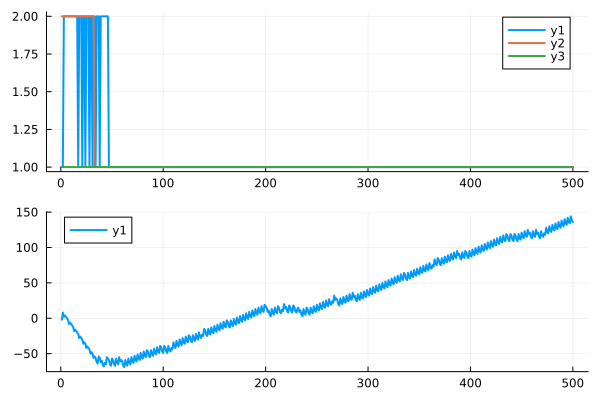

In [39]:
ag = init_greedyd_opt(en, -10.0f0, 0.1f0, 0.95f0, 0.2f0)
init_state = 2
n_itr = 500
acval_itr = zeros(Float32, n_itr, en.a_dim, en.s_dim)
pol_itr = zeros(Int, en.s_dim, n_itr)
rew_hist = zeros(Float32, n_itr)
now_state = init_state
tot_rew = 0.0f0
for trial in 1:n_itr
    a = decide_action(ag, now_state)
    next_state = sample(1:en.s_dim, ProbabilityWeights(en.pt[a,now_state,:]))
    update_Q!(ag, now_state, a, en.g[a,now_state], next_state)
    for s in 1:en.s_dim
        pol_itr[s, trial] = argmax(ag.ac_valuefn[:,s])
    end
    tot_rew += en.g[a, now_state]
    rew_hist[trial] = tot_rew
    now_state = next_state
end
println(ag.ac_valuefn)
println(final_policy(ag))
p1 = plot(pol_itr', lw=2.0)
p2 = plot(rew_hist, lw=2.0)
plot(p1, p2, layout=(2,1))

### 2-3. SARSA法

前回の$\epsilon$-greedy法においては、最適行動価値関数についてのベルマン作用素をある種標本近似する事によって、最適方策の導出を目指す手法であった。
一方でSARSA法は、行動価値関数についてのベルマン作用素を標本近似するような手法になっている。

元々の行動価値関数についてのベルマン方程式は、
$$
Q^{\pi}(s,a) = g(s,a) + \gamma\sum_{s', a'} p_t(s'|s,a) \pi(a'|s') Q(s', a') \\
\Rightarrow Q^{\pi} = B_Q Q^{\pi}
$$
であった。これを標本近似する。$\epsilon$-greedy法においては、最適行動価値関数のベルマン作用素を近似するため、第2項目は現状の$\mathrm{argmax}_{a'}Q(s',a')$で近似したが、SARSA法においては、自身が現状の方策に則って行なった実際の次の行動によって標本近似される。すなわち、更新則は、

$$
\begin{aligned}
Q^{\pi}_{new}(s_t,a_t) &= (1-\alpha) Q^{\pi}_{old}(s_t,a_t) + \alpha \left[g(s_t,a_t) + \gamma Q^{\pi}_{old}(s_{t+1},a_{t+1})\right]\\
&= Q^{\pi}_{old}(s_t,a_t) + \alpha \left[g(s_t,a_t) + \gamma Q^{\pi}_{old}(s_{t+1}, a_{t+1}) - Q^{\pi}_{old}(s_t,a_t)\right]
\end{aligned}
$$
となる。ここで更新部分に着目してみよう。$\left[g(s_t,a_t) + \gamma Q^{\pi}_{old}(s_{t+1}, a_{t+1}) - Q^{\pi}_{old}(s_t,a_t)\right]$は、ある種時刻t時点での見えている行動価値関数$Q_{old}(s_t, a_t)$と実際にもう一手進んだ時刻からから実際に見た行動価値関数$g(s_t,a_t) + \gamma Q^{\pi}_{old}(s_{t+1}, a_{t+1})$の差である。(これをTD誤差(Temporal Difference error)と呼ぶ。)ベルマン方程式を完全に満たしていればこの差はゼロになる。つまり、ここでの更新式では、「行動価値関数の一貫性」みたいなものを学習している事になる。

ここでは１ステップ先の時刻から見たものとの差を考えたが、これをnステップ先から見たものとの差に拡張する手法や、nステップ先との差を重み$\lambda^{-n}$としてTD誤差に足し上げる手法などの拡張がある。


さて実際に実装してみよう。SARSA法では、ある方策$\pi$を定め、その下での行動価値関数を導く。さらにその行動価値関数から方策を更新し、また行動価値関数をアップデートする事を繰り返す。これは、プランニング問題の章で学習した方策反復法の対応物である。

(ちなみに下ではQ関数は毎回更新しているが、それに伴う方策の更新($\pi = \mathrm{softmax}(Q_NN)$)は、50回に1回としている。これは方策反復法の名残でもあるが、本来なら毎回更新すべきなのだろう。試しにn_itr = 50を小さい値に変えてみると良いだろう。その場合方策の改善が遅くなるはずだ。「これも方策のもとで価値関数の更新は頻繁に行っても良いが、方策の更新は時々の方が良い」という経験則になっている。)

In [6]:
using Flux #今はsoftmaxを使うため。後にNNを使うためにもFluxを使う。

In [41]:
mutable struct SARSA_Duelist
    γ::Float32 #割引率
    α::Float32 #学習率
    π_as::Matrix{Float32} #方策
    Q::Matrix{Float32} #価値関数[a|s]
end

In [42]:
function init_sarsad(en::Env_duel, init::Float32, γ::Float32, α::Float32)
    π_as = zeros(Float32, en.a_dim, en.s_dim)
    #適当に方策を初期化
    for s in 1:en.s_dim
        π_as[:,s] = softmax(rand(Float32, en.a_dim))
    end
    Q = init*ones(Float32, en.a_dim, en.s_dim)
    return SARSA_Duelist(γ, α, π_as, Q)
end

init_sarsad (generic function with 1 method)

In [43]:
function decide_action(ag::SARSA_Duelist, s::Int)
    action = sample(1:size(ag.Q)[1], ProbabilityWeights(ag.π_as[:,s]))
    return action
end

decide_action (generic function with 2 methods)

In [44]:
function update_Q!(ag::SARSA_Duelist, s::Int, a::Int, r::Float32, sn::Int, an::Int)
    ag.Q[a,s] += ag.α * (r + ag.γ*ag.Q[an, sn] - ag.Q[a,s])
end

update_Q! (generic function with 2 methods)

In [45]:
#今回はϵ-greedyではなくQ関数についてのソフトマックス方策を用いている事に注意！
function update_pi!(ag::SARSA_Duelist)
    for s in 1:size(ag.Q)[2]
        ag.π_as[:,s] = softmax(ag.Q[:,s])
    end
end

update_pi! (generic function with 1 method)

In [46]:
function final_policy(ag::SARSA_Duelist)
    a_dim = size(ag.Q)[1]
    s_dim = size(ag.Q)[2]
    policy = zeros(Float32, a_dim, s_dim)
    for s in 1:s_dim
        best_action = argmax(ag.Q[:,s])
        policy[:,s] = zeros(Float32, a_dim)
        policy[best_action,s] = 1.0f0
    end
    return policy
end

final_policy (generic function with 2 methods)

Float32[6.2181745 23.252714 14.876791; 0.74909633 6.556903 26.869904]
Float32[1.0 1.0 0.0; 0.0 0.0 1.0]


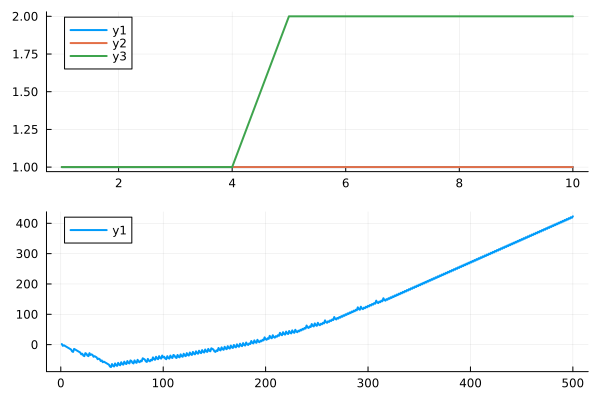

In [47]:
ag = init_sarsad(en, 10.0f0, 0.95f0, 0.2f0)
init_state = 2
n_itr = 50
pol_up = 10
acval_itr = zeros(Float32, n_itr*pol_up, en.a_dim, en.s_dim)
pol_itr = zeros(Int, en.s_dim, pol_up)
rew_hist = zeros(Float32, n_itr*pol_up)
now_state = init_state
tot_rew = 0.0f0
a_old = decide_action(ag, now_state)
for itr in 1:pol_up
    for trial in 1:n_itr  
        next_state = sample(1:en.s_dim, ProbabilityWeights(en.pt[a_old,now_state,:]))
        next_action = decide_action(ag, next_state)
        update_Q!(ag, now_state, a_old, en.g[a_old,now_state], next_state, next_action)
        tot_rew += en.g[a_old, now_state]
        rew_hist[n_itr*(itr-1)+trial] = tot_rew
        now_state = next_state
        a_old = next_action
    end
    update_pi!(ag)
    for s in 1:en.s_dim
        pol_itr[s, itr] = argmax(ag.Q[:,s])
    end
end
println(ag.Q)
println(final_policy(ag))
p1 = plot(pol_itr', lw=2.0)
p2 = plot(rew_hist, lw=2.0)
plot(p1, p2, layout=(2,1))

Float32[4.9560795 24.008688 14.016673; 2.2258809 6.8539248 27.575045]
Float32[1.0 1.0 0.0; 0.0 0.0 1.0]


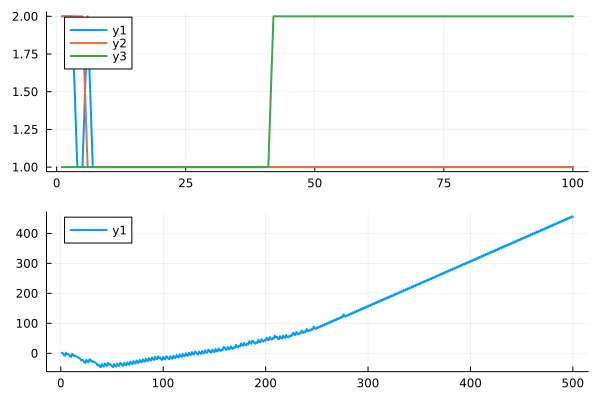

In [18]:
ag = init_sarsad(en, 10.0f0, 0.95f0, 0.2f0)
init_state = 2
n_itr = 5
pol_up = 100
acval_itr = zeros(Float32, n_itr*pol_up, en.a_dim, en.s_dim)
pol_itr = zeros(Int, en.s_dim, pol_up)
rew_hist = zeros(Float32, n_itr*pol_up)
now_state = init_state
tot_rew = 0.0f0
a_old = decide_action(ag, now_state)
for itr in 1:pol_up
    for trial in 1:n_itr  
        next_state = sample(1:en.s_dim, ProbabilityWeights(en.pt[a_old,now_state,:]))
        next_action = decide_action(ag, next_state)
        update_Q!(ag, now_state, a_old, en.g[a_old,now_state], next_state, next_action)
        tot_rew += en.g[a_old, now_state]
        rew_hist[n_itr*(itr-1)+trial] = tot_rew
        now_state = next_state
        a_old = next_action
    end
    update_pi!(ag)
    for s in 1:en.s_dim
        pol_itr[s, itr] = argmax(ag.Q[:,s])
    end
end
println(ag.Q)
println(final_policy(ag))
p1 = plot(pol_itr', lw=2.0)
p2 = plot(rew_hist, lw=2.0)
plot(p1, p2, layout=(2,1))

###  2-4. Monte-Carlo Tree Search (UCT)

前節までの手法は、$\epsilon$の確率でランダム行動を行ったり、ソフトマックス方策を採用する事により、「探索」を行ってきた。
ここでは、価値関数(評価関数)の内部に、「未探索の価値」を上乗せして、探索を行なっていく手法を考えていこう。ここではMCTSの一種であるUCT(Upper Confidential Bounds for Trees)法を採用する。元々はバンディット問題(行動によって環境の状態が変わらないような問題)について、UCB法という数学的に効率的な探索が保証されている手法があり、それを木探索に適用したものが、UCTである。(UCB1法の証明は[ここ](https://github.com/YoshihiroMichishita/YoshihiroMichishita.github.io/issues/61)に書いた。)

UCTにおける行動価値関数(評価関数)は以下で表される。
$$
\tilde{q}(s,a) = q(s,a) + u(s,a),\\
u(s,a) = \rho \sqrt{\frac{\mathrm{log}t}{m(s,a)}}
$$
$u(s,a)$が上乗せする「未探索の(探索が少ない)価値」であり、$t$はプレイ時間、$m(s,a)$は状態sで行動aを行なった経験回数(ノードへの訪問回数)である。つまりuは「プレイ時間が長い割にある特定の行動を行なったことがない場合に大きくなる」ように設計されている。$\rho$は探索の優先度を決めるパラメータである。

行動を実行する度に、自身の状態-行動ノードの訪問回数$m$と$q$を更新していく。探索中の方策は$\mathrm{argmax}_a[\tilde{q}(s,a)]$とし、最終的な方策は、探索中の方策と同じか$\pi(a|s) = m(s,a)/\sum_a m(s,a)$とする。

さて早速これを実装して、先ほどのゲームを解いてみよう(今回の実装は若干MCTSというよりはTD法っぽいかも)

In [48]:
#今回は状態・行動のペアが少ないので、行列でも計算できるが、後のAlphaZeroのために木構造のデータぽいものを使ってみよう
mutable struct Node
    m::Int #訪問回数
    q::Float32
    Child::Dict{Int, Node}
end

In [49]:
function init_node(init_q::Float32)
    return Node(0, init_q, Dict())
end

init_node (generic function with 1 method)

In [50]:
mutable struct UCT_Duelist
    turn::Int
    histrory::Vector{Int}
    c::Float32
    ρ::Float32
    α::Float32
    γ::Float32

end

function init_uctd(α::Float32, γ::Float32, ρ::Float32)
    return UCT_Duelist(0, Int[], 0.0f0, ρ, α, γ)
end

init_uctd (generic function with 1 method)

In [51]:
function calc_qbar(node::Node, ag::UCT_Duelist)
    return node.q + ag.ρ * sqrt(log(ag.turn)/(node.m+1))
end

calc_qbar (generic function with 1 method)

In [52]:
test = [1.0, 5.0, 3.0]
ass = argmax(test)
println(typeof(ass))

Int64


In [53]:
function select_child_action(en::Env_duel,node::Node, ag::UCT_Duelist)
    vals = [calc_qbar(node.Child[a], ag) for a in 1:en.a_dim]
    action::Int = argmax(vals)
    return action
end

select_child_action (generic function with 1 method)

In [54]:
function state_node_value(node::Node)
    if(isempty(node.Child))
        return node.q
    else
        ms = [node.Child[a].m for a in keys(node.Child)]
        qs = [node.Child[a].q for a in keys(node.Child)]
        return ms' * qs / sum(ms)
    end
end

state_node_value (generic function with 1 method)

In [55]:
function select_child_state(en::Env_duel,node::Node, action::Int, s::Int)
    st = sample(1:en.s_dim, ProbabilityWeights(en.pt[action, s, :]))
    return st
end

select_child_state (generic function with 1 method)

In [56]:
function tree_policy(en::Env_duel, root::Node)
    pol = zeros(Float32, en.a_dim, en.s_dim)
    for s in 1:en.s_dim
        state = root.Child[s]
        p = Float32.([state.Child[a].m for a in 1:en.a_dim])
        pol[:,s] = p/sum(p)
    end
    return pol
end

tree_policy (generic function with 1 method)

In [57]:
testd = Dict()
testd[1] = "a"
haskey(testd, 1)

true

In [58]:
itr_play = 2000
reward_hist = zeros(Float32, itr_play)
final_pl = zeros(Float32, en.a_dim, en.s_dim)
init_state = 2
init_val = 0.0f0

ag = init_uctd(0.0f0, 0.95f0, 10.0f0)

root = init_node(0.0f0)
root.Child[init_state] = init_node(init_val)
now_node = root.Child[init_state]
now_state = init_state
for itr in 1:itr_play
    ag.turn += 1
    push!(ag.histrory, now_state)
    #子ノードがなければ初期化
    if(isempty(now_node.Child))
        for a in 1:en.a_dim
            now_node.Child[a] = init_node(init_val)
        end
        println("action init")
        @show now_node.Child
    end
    
    #子ノードの中から最大のQ値を持つものを選択
    action = select_child_action(en, now_node, ag)
    #println(action)
    #push!(ag.histrory, action)
    ag.c = ag.γ*ag.c + en.g[action, now_state]
    reward_hist[itr] = ag.c

    #ノードを選択したアクションノードに移動
    action_node = now_node.Child[action]
    #訪問回数を増やす
    action_node.m += 1

    #次の状態を遷移確率に従って決定
    next_state = select_child_state(en, now_node, action, now_state)
    

    #状態ノードの情報は共有したいので、rootノードに状態ノードをなければ登録
    
    if(!haskey(root.Child, next_state))
        root.Child[next_state] = init_node(init_val)
    end
    action_node.Child[next_state] = root.Child[next_state]
    action_node.q += (en.g[action, now_state] + ag.γ*state_node_value(action_node.Child[next_state]) - action_node.q)/action_node.m
    #(ag.c - action_node.q)/action_node.m

    #状態の更新・次のノードに移動
    now_state = next_state
    now_node = root.Child[next_state]
end

policy = tree_policy(en, root)

action init
now_node.Child = Dict{Int64, Node}(2 => Node(0, 0.0f0, Dict{Int64, Node}()), 1 => Node(0, 0.0f0, Dict{Int64, Node}()))
action init
now_node.Child = Dict{Int64, Node}(2 => Node(0, 0.0f0, Dict{Int64, Node}()), 1 => Node(0, 0.0f0, Dict{Int64, Node}()))
action init
now_node.Child = Dict{Int64, Node}(2 => Node(0, 0.0f0, Dict{Int64, Node}()), 1 => Node(0, 0.0f0, Dict{Int64, Node}()))


2×3 Matrix{Float32}:
 0.785714  0.994944    0.017294
 0.214286  0.00505561  0.982706

最終的な状態の遷移も大体2と3を行ったり来たりしている(最適方策による行動と同じ)事が見て取れる

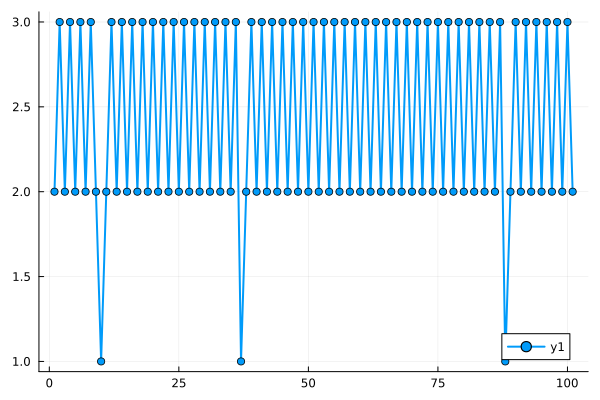

In [59]:
#plot(reward_hist, lw=2.0)
plot(ag.histrory[200:300], lw=2.0, marker=:circle)

## 3. ニューラルネットによる関数近似

### 3-1. deep-Q net(with SARSA)

さてここからニューラルネットを用いた強化学習について見ていこう！
今回考えてる問題は、$|\mathcal{A}||\mathcal{S}|$が小さいので問題にならなかったが、これが大きくなってくるとメモリとして保持するのは不可能になってくる。例えば将棋を例に考えてみると、駒の種類が８種類(＋成駒6種類)\* 2(どちらの駒か)が81マス＋持ち駒にそれぞれ配置されるので、雑な見積もりで$|\mathcal{S}| \sim $ 29(駒の種類\*2+空白)^(80)くらいの状態空間があって、それぞれのターンに20個くらいの駒のどれかを動かすのでまた $|\mathcal{A}|\sim 20$ くらいはあるので、当然全てを記憶させておくのは不可能だろう。そこで$Q(s,a)$を何かしらの関数$q_a = f(s)$だと思って、その関数$f$を(ディープ)ニューラルネットで関数近似($f\sim f_{NN;\theta}$)する事を試みる。これによってある種潜在空間に落とし込み、メモリの意味で効率的に$Q(s,a)$を保持・学習しようというのが、deep-Q network (DQN)である。

今回はSARSA法にdeep-Q network(DQN)を適用してみよう。また今回考える問題は簡単なので、本来はNNを使わなくても良い事を繰り返し述べておく。(というか今回くらい簡単だとNN使った方がパラメータ数多くなる)

In [60]:
mutable struct SARSA_NN_Duelist
    γ::Float32 #割引率
    #α::Float32 #学習率
    π_as::Matrix{Float32} #方策
    Q::Chain #価値関数[a|s]を近似するNN
    opt #ニューラルネットのパラメータの最適化手法
    l_hist::Vector{Float32}#loss関数の履歴
end

function init_sarsa_nn_d(en::Env_duel, γ::Float32, α::Float32)
    π_as = zeros(Float32, en.a_dim, en.s_dim)
    #適当に方策を初期化
    for s in 1:en.s_dim
        π_as[:,s] = softmax(rand(Float32, en.a_dim))
    end
    #s_dim => 16 * tanh => 16* tanh => a_dim
    # Dense(in_dim, out_dim, activation_fn)で全結合層を作る事が出来、Chainで繋げる事が出来る。Chainは中に適当な関数も入れる事が出来る。
    Q = Chain(Dense(en.s_dim, 16, relu), Dense(16, 16, relu), Dense(16, en.a_dim))
    #今回は幅広く使われているAdamを用いる
    opt = ADAM(α)
    l_hist = Float32[]
    return SARSA_NN_Duelist(γ, π_as, Q, opt, l_hist)
end

init_sarsa_nn_d (generic function with 1 method)

In [61]:
#piに従って行動選択。今回もQ値からのsoftmax方策とする。
function decide_action(ag::SARSA_NN_Duelist, s::Int)
    action = sample(1:size(ag.π_as)[1], ProbabilityWeights(ag.π_as[:,s]))
    return action
end

# NNに入れる用の状態ベクトルを作る関数
function onehot3(s::Int)
    s_vec = zeros(Int32, 3)
    s_vec[s] = 1
    return s_vec
end

## NNで関数近似したQを更新。TD誤差の２乗をloss関数とする。(TD誤差=0でベルマン方程式を満たす&解になるため)
function learning_Q!(ag::SARSA_NN_Duelist, s::Int, a::Int, r::Float32, sn::Int, an::Int)
    s_vec = onehot3(s)
    sn_vec = onehot3(sn)

    #損失と勾配を計算
    val, grads = Flux.withgradient(Flux.params(ag.Q)) do 
        loss = abs(r + ag.γ* ag.Q(sn_vec)[an] - ag.Q(s_vec)[a])^2
    end
    #勾配からNNのパラメータをアップデート
    Flux.Optimise.update!(ag.opt, Flux.params(ag.Q), grads)
    push!(ag.l_hist, val)
end

#方策をupdate
function update_pi!(ag::SARSA_NN_Duelist)
    for s in 1:size(ag.π_as)[2]
        s_vec = onehot3(s)
        ag.π_as[:,s] = softmax(ag.Q(s_vec))
    end
end

update_pi! (generic function with 2 methods)

Q関数を近似するNNが雑だったせいかlossはあんまり小さくならないけど最適方策は導けているのでヨシ！

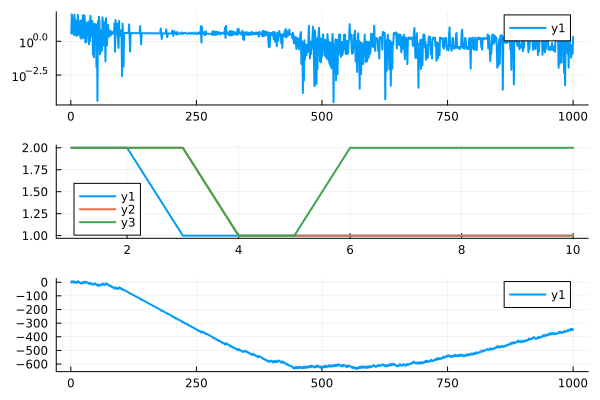

In [62]:
ag = init_sarsa_nn_d(en, 0.95f0, 0.005f0)
init_state = 2
n_itr = 100
pol_up = 10
acval_itr = zeros(Float32, n_itr*pol_up, en.a_dim, en.s_dim)
pol_itr = zeros(Int, en.s_dim, pol_up)
rew_hist = zeros(Float32, n_itr*pol_up)
now_state = init_state
tot_rew = 0.0f0
a_old = decide_action(ag, now_state)
for itr in 1:pol_up
    for trial in 1:n_itr  
        next_state = sample(1:en.s_dim, ProbabilityWeights(en.pt[a_old,now_state,:]))
        next_action = decide_action(ag, next_state)
        learning_Q!(ag, now_state, a_old, en.g[a_old,now_state], next_state, next_action)
        tot_rew += en.g[a_old, now_state]
        rew_hist[n_itr*(itr-1)+trial] = tot_rew
        now_state = next_state
        a_old = next_action
    end
    update_pi!(ag)
    for s in 1:en.s_dim
        pol_itr[s, itr] = argmax(ag.Q(onehot3(s)))
    end
end
p1 = plot(ag.l_hist, lw = 2.0, yaxis=:log10)
p2 = plot(pol_itr', lw=2.0)
p3 = plot(rew_hist, lw=2.0)
plot(p1, p2, p3, layout=(3,1))

### 3-2. Dual Deep Neural Network(with Actor-Critic & Policy Gradient Method)

前節のSARSA法は、方策反復法の標本近似の一種であることは既に述べたが、より直接的に近いActor-Critic法についても紹介したい。Actor-Criti法では、方策$\pi$を持っているアクターと、評価関数$V(S)$を持っている批評家がおり、それぞれが学習を行っていく手法である。適用できる問題の幅や手法の柔軟性があるのが売りである。Actor-Critic法では、方策を明示的にNNから与える(Q関数からsoftmaxとかではなく)ために、方策勾配法を用いる事が出来るのでこれも説明していく。

#### 3-2-1. Dual Neural Network
Actor-Critic法をNNで関数近似する場合、素朴な手法では、Actorの方策を近似するNNとCriticの評価関数を近似するNNの二つが必要になる。一方で、方策と評価関数を決める際は、「何かしらの状況整理・状況の解釈をそれぞれ頭の中でしていて、そこからそれぞれの方策や評価関数を決定している」と考えれば、状況整理までのNNは共有していても良いのでは？という考えに至る。

これがDual Deep Neural Networkである。
途中までNNを共有し、終盤のn層で独立してそれぞれ方策と価値関数を与えるようにする。

#### 3-2-2. 方策勾配法

これまで得られる報酬の総和(厳密には割引率を都度かけたもの)を最大化するような方策を導出する事を行なってきました。これはある方策$\pi$に従って、一定時間行動した際に得られる報酬の総和を最大化することにも置き換えられます
$$
J(\theta) = E_{\{a_t, s_t\}\sim \pi_{\theta}} [G_0(\{a_t\},\{s_t\})]\\
G_0(\{a_t\},\{s_t\}) = r_0(a_0, s_0) + \gamma r_1(a_1, s_1) + \dots + \gamma^t r_t(a_t, s_t)
$$
これの勾配を計算して、少しずつ大きくなるようにパラメータを更新していく。これが方策勾配法です。この勾配は、
$$
\begin{aligned}
\nabla_{\theta} J(\theta) &= \nabla_{\theta}E_{\{a_t, s_t\}\sim \pi_{\theta}} [G(\{a_t\},\{s_t\})]\\
&= E_{\{a_t, s_t\}\sim \pi_{\theta}} [G_{t'}(\{a_t\},\{s_t\}) \nabla_{\theta} \mathrm{log}[\pi(a_{t'}|s_{t'})]]\\
G_{t'}(\{a_t\},\{s_t\}) &= r_{t'}(a_{t'}, s_{t'})+ \dots + \gamma^{t-t'} r_t(a_t, s_t)
\end{aligned}
$$
となります。ここで$E_{a,s\sim\pi}$ではaについて確率でサンプリングをしているので、状態sに依存するような項を足しても定数になり、微分すれば消えるので、
$$
\begin{aligned}
\nabla_{\theta} J(\theta) &=\nabla_{\theta}E_{\{a_t, s_t\}\sim \pi_{\theta}} [G(\{a_t\},\{s_t\})- V(s_t)]\\
&= E_{\{a_t, s_t\}\sim \pi_{\theta}} [(G_{t'}(\{a_t\},\{s_t\})-V(s_t)) \nabla_{\theta} \mathrm{log}[\pi(a_{t'}|s_{t'})]]\\
&= \sum_{t} E_{a_t\sim\pi}[(r_t + \gamma V(s_{t+1}) - V(s_t)) \nabla_{\theta} \mathrm{log}[\pi(a_{t}|s_{t})]]
\end{aligned}
$$
のように書き換えることも出来ます。今回は$V(s)$の部分もNNによる評価に近似して、この方策勾配を計算することになります。

$\epsilon$-greegy法などでは、方策はargmaxによって決めていたので勾配を用いる事は出来ませんでした。mctsやuctについても同様にargmaxを取るので使えないはずです。(方策由来で探索をしないので)


Dual Networkで学習を行う場合は、(TD誤差の二乗) + (方策勾配ロス) - (正則化のための方策エントロピー)をロス関数として学習します。
方策エントロピーは、序盤で探索を行いたい時に、方策を行動確率を均等にしようとする効果があり、以下でかけます。
$$
-\sum_a \pi(a|s) \mathrm{log} \pi(a|s)
$$
これは完全に均等な確率の時に最大となり、極端な方策の際に0となります。こうする事で、方策の分布をぼやかして、探索を誘発します。


さてこれを実装してみよう。また方策を都度更新すると学習が安定しないので、ある程度回数を行動しデータを貯めてから学習を行うという方針をとる。(ちなみにそれでもあまりうまく行かないはずだ。その改善手法を後に説明する。)

In [63]:
mutable struct AC_NN_Duelist
    γ::Float32 #割引率
    α::Float32 #方策勾配の学習率
    β::Float32 #方策エントロピーの学習率
    #π_as::Matrix{Float32} #方策
    dual::Chain #価値関数[a|s]と方策を近似するNN
    opt #ニューラルネットのパラメータの最適化手法
    l_hist::Vector{Float32}#loss関数の履歴
    memory
end
tanh3(x) = 3tanh(x/3)
function init_ac_nn_d(en::Env_duel, γ::Float32, α::Float32, β::Float32, η::Float32)
    
    width = 16

    #Flux.Parallel(vcat, Chian(A), Chain(B))で出力を分割してNNに入れ最後にまとめて出力できる。Flux.Parallel(+, Chian(A), Chain(B))とかにすると最後に足しあげる(dueling NNとかを採用する場合はこれを使う。)
    #s_dim => 16 * relu (=> 16* relu)*2 => (=> 16* relu)*2 => a_dim => softmax
    #                                    =>  (=> 16* relu)*2 => 1 (V(s))
    dual = Chain(Dense(en.s_dim, width, relu), Dense(width, width, relu), Dense(width, width, relu), Flux.Parallel(vcat,Chain(Dense(width, width, relu), Dense(width, width, relu), Dense(width, en.a_dim, tanh3), softmax), Chain(Dense(width, width, relu), Dense(width, width, relu), Dense(width, 1))))
    
    opt = ADAM(η)
    l_hist = Float32[]
    memory = []
    
    return AC_NN_Duelist(γ, α, β, dual, opt, l_hist, memory)
end

init_ac_nn_d (generic function with 1 method)

In [64]:
#piに従って行動選択。
function decide_action(en::Env_duel,ag::AC_NN_Duelist, s::Int)
    s_vec = onehot3(s)
    action = sample(1:en.a_dim, ProbabilityWeights(ag.dual(s_vec)[1:end-1]))
    return action
end

decide_action (generic function with 4 methods)

In [73]:
function logvec(v)
    return [log(v[i]) for i in 1: length(v)]
end

function loss_fn(ag::AC_NN_Duelist, s_vec::Vector{Int32}, a::Int, r::Float32, sn_vec::Vector{Int32})
    adv = r + ag.γ*ag.dual(sn_vec)[end] - ag.dual(s_vec)[end]
    adv_loss = (adv)^2
    pp = ag.dual(s_vec)[1:end-1]
    pol_grad = adv * log(pp[a])
    #pol_entr = pp[a] * log(pp[a])
    pol_entr = pp' * logvec(pp)

    loss = ag.α*adv_loss - pol_grad + ag.β * pol_entr
    return loss
end

function onehot3(s::Int)
    s_vec = zeros(Int32, 3)
    s_vec[s] = 1
    return s_vec
end

function loss_fn_batch(ag::AC_NN_Duelist)
    loss = 0.0f0
    L = length(ag.memory)
    for i in 1:L
        #s, a, r, sn = ag.memory[i]
        #s_vec = onehot3(s)
        #sn_vec = onehot3(sn)
        #loss += loss_fn(ag, s_vec, a, r, sn_vec)
        loss += loss_fn(ag, ag.memory[i]...)
    end
    return loss/L
end

loss_fn_batch (generic function with 1 method)

In [70]:
function learning_vp!(ag::AC_NN_Duelist)
    #s_vec = onehot3(s)
    #sn_vec = onehot3(sn)
    for itr in 1:200
        val, grads = Flux.withgradient(Flux.params(ag.dual)) do 
            loss_fn_batch(ag)
        end
        #勾配からNNのパラメータをアップデート
        Flux.Optimise.update!(ag.opt, Flux.params(ag.dual), grads)
        push!(ag.l_hist, val)
    end
end

learning_vp! (generic function with 1 method)

In [80]:
ag = init_ac_nn_d(en, 0.95f0, 10.0f0, 10.0f0, 0.002f0)
init_state = 2
n_itr = 100
pol_up = 20
acval_itr = zeros(Float32, n_itr*pol_up, en.a_dim, en.s_dim)
pol_itr = zeros(Int, en.s_dim, pol_up)
rew_hist = zeros(Float32, pol_up)
now_state = init_state
tot_rew = 0.0f0

for itr in 1:pol_up
    for trial in 1:n_itr  
        a = decide_action(en, ag, now_state)
        next_state = sample(1:en.s_dim, ProbabilityWeights(en.pt[a,now_state,:]))
        #next_action = decide_action(en, ag, next_state)
        r = en.g[a,now_state]
        push!(ag.memory, (onehot3(now_state), a, r, onehot3(next_state)))
        #learning_vp!(ag, now_state, a, r, next_state)
        #tot_rew += r
        rew_hist[itr] += r
        now_state = next_state
        #a_old = next_action
    end
    learning_vp!(ag)
    ag.memory = []
    for s in 1:en.s_dim
        pol_itr[s, itr] = argmax(ag.dual(onehot3(s))[1:end-1])
    end
end

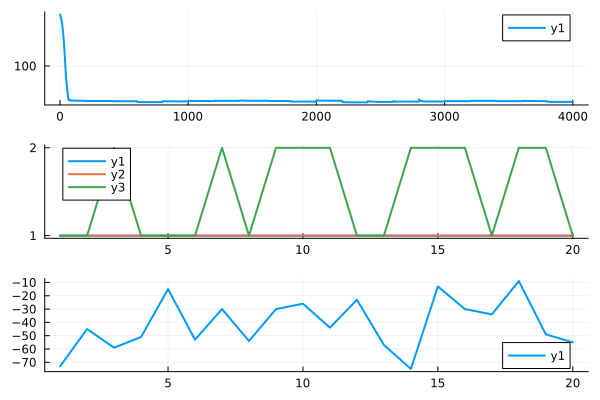

In [81]:

p1 = plot(ag.l_hist, lw = 2.0, yticks=[0, 1, 10, 100])
#p1 = plot(ag.l_hist, lw = 2.0, yaxis=:log10)
p2 = plot(pol_itr', lw=2.0, yticks = [1,2])

p3 = plot(rew_hist, lw=2.0)
plot(p1, p2, p3, layout=(3,1))

### 3-3. TRPO(Trust Region Policy Optimization)

上記の結果を見るとわかるが、方策勾配法は学習が安定しない事が多い。その理由の１つに学習率の設定が難しい事がある。大きいと学習が全く安定しないし、小さいと収束までかなり時間がかかる。

そこでその学習の安定性を保証する手法がTRPO(Trust Region Policy Optimization)である。

一度に方策がガラリと変わってしまう事を避けたいので、その対策として、方策(の確率分布)の変化量に上限を設けて、その制限下で変数のアップデートを行う。確率分布の変化量としては、確率分布間の(擬)距離で定義するのが自然であろうので、KL-divergenceで定義する。すなわち
$$
D_{KL}(\pi_{\theta_{old}}(a|s)||\pi_{\theta_{new}}(a|s)) = \sum_a \pi_{\theta_{old}}(a|s) \mathrm{log} (\pi_{\theta_{old}}(a|s) / \pi_{\theta_{new}}(a|s))
$$
に対して、制約条件
$$
D_{KL}(\pi_{\theta_{old}}(a|s)||\pi_{\theta_{new}}(a|s)) < \epsilon
$$
を課しながらパラメータを更新していく。

しかし、この制約条件を真面目に考えながらパラメータ更新をするのは難しいので、更新量$\delta\theta = \theta_{new}-\theta_{old}$が十分小さいと思って、
$$
D_{KL}(\pi_{\theta_{old}}(a|s)||\pi_{\theta_{new}}(a|s)) \simeq \frac{1}{2} \delta\theta^T H \delta\theta\\
H_{ij} = \frac{\partial^2}{\partial\theta_i\partial\theta_j}D_{KL}(\pi_{\theta_{old}}(a|s)||\pi_{\theta_{new}}(a|s))
$$
で近似する。

さらに更新するときの方策勾配についてのロス関数の変化量は、一次の近似で
$$
\delta L(\theta) \simeq g^T \delta\theta
$$
となるので、上記の制約下でこの変化量を最大化したい。(早く収束させたいので)

すなわち問題は(ラグランジュの未定乗数法を用いて)
$$
\tilde(L)(\delta\theta) = g^T \delta\theta + \lambda (\epsilon - \delta\theta^T H \delta\theta)
$$
を最大化する問題である。$\delta\theta$に対する停留条件から
$$
\frac{\partial}{\partial\delta\theta}\tilde(L)(\delta\theta) = 0\\
\Rightarrow g^T - \lambda \delta\theta^T H = 0\\
\Rightarrow \delta\theta = \frac{1}{\lambda} H^{-1} g
$$
さらに
$$
\frac{1}{2} \delta\theta^T H \delta\theta = \frac{1}{\lambda^2}g^T H^{-1} g = \epsilon\\
\Rightarrow \lambda = \sqrt{\frac{1}{\epsilon} g^T H^{-1} g}
$$
となります。

よって、パラメータの更新則として
$$
\theta_{new} = \theta_{old} + \sqrt{\frac{\epsilon}{g^T H^{-1} g}}H^{-1} g
$$
とすれば、方策が大幅に変わる事を防ぎつつ、十分に更新が出来る事が分かりました。これがTRPOの手法です。

しかし、Hはニューラルネットのパラメータについて2回微分をしなければならないのでパラメータ数についてO(N^3)かかり、それをパラメータ更新の度に計算するのは現実的ではない。近似的に計算する手法もあるものの、基本的にはTRPOは理論は美しいが扱いづらいという立ち位置であるように思う。

### 3-4. PPO(Proximal Policy Optimization)

上記で方策の急激な変化を禁止しつつ最大限パラメータを更新してくれる手法としてTRPOを導入した。しかし一方でTRPOの真面目な計算には時間がかかる事が多い。

そこでTRPOを簡略化して速度を優先させつつも、収束性をある程度持たせる手法がPPOである。OpenAIなどは、この手法を基本的に使っているらしい。(ChatGPTのRLHF(Reinforcement Learning with Human Feedback)などにも使われているらしい。)

少し話を戻して方策勾配法の話を振り返ってみよう。パラメータを更新した際に
$$
A_t = r_t(s_t, a_t) + \gamma V(s_{t+1}) - V(s_t)
$$
としておいて、
$$
\begin{aligned}
J(\theta_{new}) &= \sum_t \pi_{\theta_{new}}(a_t|s_t) A_t \\
    &= \sum_t \pi_{\theta_{old}}(a_t|s_t) \left(\frac{\pi_{\theta_{new}}(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\right) A_t
\end{aligned}
$$
なる目的関数を最大化したい。($\{a_t\}$をサンプリングする際に$\pi_{old}$を使っているので、２行目の式変形を行った。)ここで方策$\pi$が大きく変わらないようにKL-divergenceについて制約を入れたのがTRPOであった。

この「方策$\pi$が大きく変わらない」という制約を、「上式２行目の$\pi_{\theta_{new}}/\pi_{\theta_{new}}$の値を1付近に留める」という制約に言い換える事が出来るだろう。
以降$r_{\theta_{new}, \theta_{old}}(s_t, a_t) = \pi_{\theta_{new}}/\pi_{\theta_{new}}$とする。

$J(\theta_{new})$を大きくしたいので、$A_t$が正の値の時は大きくしたいが制限するので$r_{\theta_{new}, \theta_{old}} = \mathrm{min}(r_{\theta_{new}, \theta_{old}} ,1+\mathrm{clip})$とし、$A_t$が負の値の時は小さくしたいのを制限するで$r_{\theta_{new}, \theta_{old}} = \mathrm{max}(r_{\theta_{new}, \theta_{old}} ,1-\mathrm{clip})$とする。

このPPOについてはTRPOでのヘッセ行列の計算のような計算量の問題は発生しないので非常に計算がしやすく、かなり汎用性もある。

ちなみにPPOではAdvantage Estimation($A_t$)の代わりにGAE(Generalized Advantage Estimation)を用いる場合が多い。今回は使わないが、定義を書いておく。
$$
\tilde{A}_t = A_t + \gamma\lambda A_{t+1} + \dots + (\gamma\lambda)^{T-t+1}A_{T-1}
$$

さてPPOを実装してみよう!

In [82]:
function clip(r::Float32, c::Float32, adv::Float32)
    if(adv>0)
        return min(r, Float32(1+c))*adv
    else
        return max(r, Float32(1-c))*adv
    end
end

clip (generic function with 1 method)

In [83]:

function loss_fn_ppo(ag::AC_NN_Duelist, s_vec::Vector{Int32}, a::Int, r::Float32, sn_vec::Vector{Int32}, old_model::Chain, c::Float32)
    adv = r + ag.γ*ag.dual(sn_vec)[end] - ag.dual(s_vec)[end]
    adv_loss = (adv)^2
    p_new = ag.dual(s_vec)[1:end-1]
    p_old = old_model(s_vec)[a]
    rc = p_new[a] / p_old

    pol_entr = p_new' * logvec(p_new)

    ppo_loss = -clip(rc, c, adv) + ag.α*adv_loss + ag.β * pol_entr
    return ppo_loss
end

function loss_fn_ppo_batch(ag::AC_NN_Duelist, old_model::Chain, c::Float32)
    loss = 0.0f0
    L = length(ag.memory)
    for i in 1:L
        #s, a, r, sn = ag.memory[i]
        #s_vec = onehot3(s)
        #sn_vec = onehot3(sn)
        #loss += loss_fn(ag, s_vec, a, r, sn_vec)
        loss += loss_fn_ppo(ag, ag.memory[i]..., old_model, c)
    end
    return loss / L
end

loss_fn_ppo_batch (generic function with 1 method)

In [84]:
function learning_vp!(ag::AC_NN_Duelist, old_model::Chain, c::Float32)
    #s_vec = onehot3(s)
    #sn_vec = onehot3(sn)
    for itr in 1:100
        #println(loss_fn_ppo_batch(ag, old_model, c))
        
        val, grads = Flux.withgradient(Flux.params(ag.dual)) do 
            loss_fn_ppo_batch(ag, old_model, c)
        end
        #勾配からNNのパラメータをアップデート
        Flux.Optimise.update!(ag.opt, Flux.params(ag.dual), grads)
        push!(ag.l_hist, val)
    end
end

learning_vp! (generic function with 2 methods)

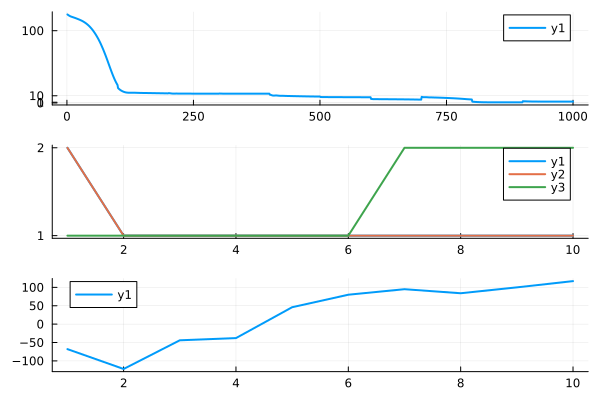

In [85]:
ag = init_ac_nn_d(en, 0.95f0, 5.0f0, 0.01f0, 0.001f0)
init_state = 2
n_itr = 100
pol_up = 10
acval_itr = zeros(Float32, n_itr*pol_up, en.a_dim, en.s_dim)
pol_itr = zeros(Int, en.s_dim, pol_up)
rew_hist = zeros(Float32, pol_up)
now_state = init_state
tot_rew = 0.0f0

for itr in 1:pol_up
    for trial in 1:n_itr  
        a = decide_action(en, ag, now_state)
        next_state = sample(1:en.s_dim, ProbabilityWeights(en.pt[a,now_state,:]))
        #next_action = decide_action(en, ag, next_state)
        r = en.g[a,now_state]
        push!(ag.memory, (onehot3(now_state), a, r, onehot3(next_state)))
        #learning_vp!(ag, now_state, a, r, next_state)
        #tot_rew += r
        rew_hist[itr] += r
        now_state = next_state
        #a_old = next_action
    end
    old_model = deepcopy(ag.dual)
    learning_vp!(ag, old_model, 0.2f0)
    ag.memory = []
    for s in 1:en.s_dim
        pol_itr[s, itr] = argmax(ag.dual(onehot3(s))[1:end-1])
    end
end
p1 = plot(ag.l_hist, lw = 2.0, yticks=[0, 1, 10, 100])
#p1 = plot(ag.l_hist, lw = 2.0, yaxis=:log10)
p2 = plot(pol_itr', lw=2.0, yticks = [1,2])

p3 = plot(rew_hist, lw=2.0)
plot(p1, p2, p3, layout=(3,1))

### 3-5. SAC(Soft Actor-Critic method)

上記のPPOは、学習の安定性は高いのだが、方策が更新されるごとにサンプルを棄却しなければならない(「On-Policy」と呼ぶ)ので、一般に学習に多くのサンプルを必要とする(今回くらい簡単な問題だとそこまで問題にならない)。そこでPPOの代わりに、価値関数Vにエントロピー項を入れる事で、方策が極端に更新される(特定の行動だけをするように(過)学習する)事を防ぐという方針が考えられる。すなわち、

$$
V(s_{t+1}) = \sum_a p_T(s_{t+1}|s_{t},a_{t})\pi(a_{t}|s_{t}) [Q(s_{t},a_{t}) - \alpha_T  \mathrm{log}\pi(a_{t}|s_{t})]
$$
として、ベルマン方程式を設定する。さらに価値関数の急激な変化を防ぐための手法として、右辺に出てくる行動価値関数を移動平均価値関数$\bar{Q}$としておき、行動価値関数を決めるネットワークのパラメータ$\theta$の更新が終わった後に、移動平均行動価値関数$\bar{Q}$のパラメータを$\bar{\theta} = \tau \theta + (1-\tau)\bar{\theta}$で少しづつ更新していく事にする。こうする事でバイアスが減る事が(経験的に？)知られている。

また方策の更新をQ関数をsoftmaxして得られる方策とのKL距離を最小化するように行うことにする。これによって方策を更新したとしても過去のサンプルが使えるようになる。(ただsoftmax型のQ学習と何が違うんだ感は感じる)

連続の行動空間では、SACはSOTA(最高水準)の手法の一つなので、これの離散行動空間版について実装してみよう。
(連続の行動空間版では、reparametrization trickというVAEなどで使われている手法を組み入れる必要がある事だけコメントしておく。)

先ほどは、dual network(policy-value network)というpolicy networkとvalue networkが途中までパラメータを共有したNNを用いていたが、ここでは分離したものを用いる。

In [7]:
using LinearAlgebra, Plots, StatsBase, Flux

In [60]:
tanh2(x) = 2tanh(x/10)

tanh2 (generic function with 1 method)

In [63]:
mutable struct SAC_NN_Duelist
    γ::Float32 #割引率
    α::Float32 #方策エントロピーについての温度
    τ::Float32 #移動平均価値関数の更新率
    #π_as::Matrix{Float32} #方策
    Q::Chain #価値関数[a|s]を近似するNN
    #Qb::Chain #移動平均価値関数[a|s]を近似するNN
    π_act::Chain #方策NN
    opt_Q #ニューラルネットのパラメータの最適化手法
    opt_π #ニューラルネットのパラメータの最適化手法
    memory
    l_hist::Vector{Float32}#loss関数の履歴
end

function init_sac_nn_d(en::Env_duel, γ::Float32, α::Float32, τ::Float32, η::Float32)
    
    width = 16

    #Flux.Parallel(vcat, Chian(A), Chain(B))で出力を分割してNNに入れ最後にまとめて出力できる。Flux.Parallel(+, Chian(A), Chain(B))とかにすると最後に足しあげる(dueling NNとかを採用する場合はこれを使う。)
    #s_dim => 16 * relu (=> 16* relu)*2 => (=> 16* relu)*2 => a_dim => softmax
    #                                    =>  (=> 16* relu)*2 => 1 (V(s))
    Q = Chain(Dense(en.s_dim, width, relu), Dense(width, width, relu), Dense(width, width, relu), Dense(width, en.a_dim))
    π_act = Chain(Dense(en.s_dim, width, relu), Dense(width, width, relu), Dense(width, width, relu), Dense(width, en.a_dim), softmax)

    
    opt_Q = ADAM(3η)
    opt_π = ADAM(η)
    l_hist = Float32[]
    memory = []
    
    return SAC_NN_Duelist(γ, α, τ, Q, π_act, opt_Q, opt_π, memory, l_hist)
end

init_sac_nn_d (generic function with 1 method)

In [12]:
function onehot3(s::Int)
    s_vec = zeros(Int32, 3)
    s_vec[s] = 1
    return s_vec
end
#piに従って行動選択。
function decide_action(en::Env_duel,ag::SAC_NN_Duelist, s::Int)
    s_vec = onehot3(s)
    action = sample(1:en.a_dim, ProbabilityWeights(ag.π_act(s_vec)))
    return action
end

function random_action(en::Env_duel)
    return rand(1:en.a_dim)
end

random_action (generic function with 1 method)

In [72]:
function logvec(v)
    return [log(v[i]) for i in 1: length(v)]
end

function loss_Q(ag::SAC_NN_Duelist, s_vec::Vector{Int32}, a::Int, r::Float32, sn_vec::Vector{Int32}, Qb::Chain)
    an_pi = ag.π_act(sn_vec)
    adv = r + ag.γ*an_pi'*(Qb(sn_vec) - ag.α*logvec(an_pi)) - ag.Q(s_vec)[a]

    loss = adv^2
    return loss
end

function loss_π(ag::SAC_NN_Duelist, s_vec::Vector{Int32})
    a_pi = ag.π_act(s_vec)
    KL = a_pi'*(ag.α*logvec(a_pi) - ag.Q(s_vec))

    return KL
end


function loss_Q_batch(ag::SAC_NN_Duelist,Qb::Chain, batch)
    loss = 0.0f0
    #batch = sample(memory, batch_size, replace=true)
    for b in batch
        loss += loss_Q(ag, b..., Qb)
    end
    return loss/length(batch)
end

function loss_π_batch(ag::SAC_NN_Duelist, batch)
    loss = 0.0f0
    #batch = sample(memory, batch_size, replace=true)
    for b in batch
        loss += loss_π(ag, b[1])
    end
    return loss/length(batch)
end

function training_update!(ag::SAC_NN_Duelist, Qb::Chain, batch_size::Int, training_step::Int)
    p0 = 0.0f0
    for itr in 1:training_step
        batch = sample(ag.memory, batch_size, replace=true)
        valQ, gradsQ = Flux.withgradient(Flux.params(ag.Q)) do 
            loss_Q_batch(ag, Qb, batch)
        end
        #勾配からNNのパラメータをアップデート
        Flux.Optimise.update!(ag.opt_Q, Flux.params(ag.Q), gradsQ)
        push!(ag.l_hist, valQ)
        valp, grads = Flux.withgradient(Flux.params(ag.π_act)) do 
            loss_π_batch(ag, batch)
        end
        #勾配からNNのパラメータをアップデート
        Flux.Optimise.update!(ag.opt_π, Flux.params(ag.π_act), grads)
        #m_length = length(ag.Q)
        p1, re1 = Flux.destructure(ag.Q)
        p2, re2 = Flux.destructure(Qb)
        p2 = ag.τ * p1 + (1.0f0-ag.τ) * p2
        Qb = re2(p2)
        p0 += valp/training_step
        #Flux.params(Qb) = [(ag.τ * Flux.params(ag.Q)[i] + (1.0f0-ag.τ) * Flux.params(Qb)[i]) for i in 1:m_length]
    end
    println(p0)
end

training_update! (generic function with 1 method)

-14.546394
:Q_pi1Float32[0.43738636, 0.5626136]
:Q_pi2Float32[0.47906303, 0.520937]
:Q_pi3Float32[0.5963299, 0.4036701]
:Q_pi3Float32[0.97769505, 0.022304958], Float32[18.73708, 14.956691])
-6.3247027
:Q_pi1Float32[0.38139933, 0.61860067]
:Q_pi2Float32[0.44187546, 0.5581245]
:Q_pi3Float32[0.683261, 0.31673902]
:Q_pi3Float32[0.9730152, 0.026984775], Float32[13.558011, 9.972884])
-2.439516
:Q_pi1Float32[0.2781797, 0.7218203]
:Q_pi2Float32[0.37843904, 0.621561]
:Q_pi3Float32[0.8200142, 0.17998585]
:Q_pi3Float32[0.9712803, 0.028719725], Float32[11.033679, 7.512648])
0.16426797
:Q_pi1Float32[0.1299112, 0.8700888]
:Q_pi2Float32[0.24412419, 0.75587577]
:Q_pi3Float32[0.8675352, 0.13246481]
:Q_pi3Float32[0.9372399, 0.062760144], Float32[9.924872, 7.2212534])
1.0852083
:Q_pi1Float32[4.20572f-5, 0.9999579]
:Q_pi2Float32[0.009207017, 0.99079293]
:Q_pi3Float32[0.9949903, 0.005009702]
:Q_pi3Float32[0.98442775, 0.015572299], Float32[10.072494, 5.9259267])


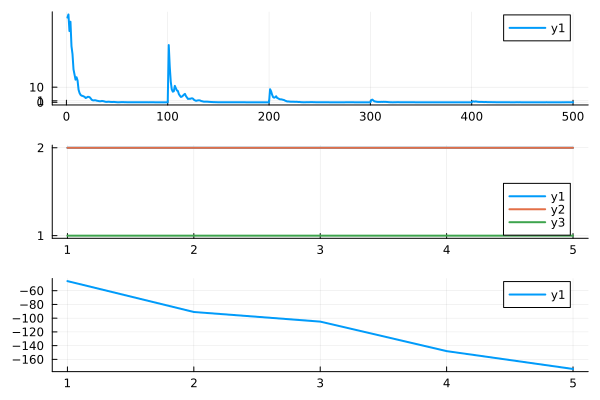

In [73]:
ag = init_sac_nn_d(en, 0.98f0, 10f0, 0.01f0, 0.01f0)
init_state = 3
n_itr = 100
pol_up = 5
acval_itr = zeros(Float32, n_itr*pol_up, en.a_dim, en.s_dim)
pol_itr = zeros(Int, en.s_dim, pol_up)
rew_hist = zeros(Float32, pol_up)
now_state = init_state
tot_rew = 0.0f0

Qb = deepcopy(ag.Q)
for itr in 1:pol_up
    for trial in 1:n_itr
        if(itr == 1)
            a = random_action(en)
        else
            a = decide_action(en, ag, now_state)
        end
        #a = decide_action(en, ag, now_state)
        next_state = sample(1:en.s_dim, ProbabilityWeights(en.pt[a,now_state,:]))
        #next_action = decide_action(en, ag, next_state)
        r = en.g[a,now_state]
        push!(ag.memory, (onehot3(now_state), a, r, onehot3(next_state)))
        #learning_vp!(ag, now_state, a, r, next_state)
        #tot_rew += r
        rew_hist[itr] += r
        now_state = next_state
        #a_old = next_action
    end
    training_update!(ag, Qb, 300, 100)
    for s in 1:en.s_dim
        pol_itr[s, itr] = argmax(ag.π_act(onehot3(s)))
        #println(maximum(ag.π_act(onehot3(s))))
    end
    ag.α *= 0.5f0
    println(":Q_pi1$(ag.π_act(onehot3(1)))")
    println(":Q_pi2$(ag.π_act(onehot3(2)))")
    println(":Q_pi3$(ag.π_act(onehot3(3)))")
    println(":Q_pi3$(softmax(ag.Q(onehot3(3)))), $(ag.Q(onehot3(3))))")
    ag.memory = []
end
p1 = plot(ag.l_hist, lw = 2.0, yticks=[0, 1, 10, 100])
#p1 = plot(ag.l_hist, lw = 2.0, yaxis=:log10)
p2 = plot(pol_itr', lw=2.0, yticks = [1,2])

p3 = plot(rew_hist, lw=2.0)
plot(p1, p2, p3, layout=(3,1))

### 3-6. Alpha Zero

さて、最後にAlphaZeroの手法について学ぼう。UCTにおいて、行動価値関数に探索の価値$u$を付与する事で、効率的に探索を行うことが出来、かつ過小評価してしまう確率を抑えつつ収束に向かわせることが出来た。

しかし、木探索においては、木の深さや状態数の広さが大きくなってくると収束に必要な探索数は爆発的に上がっていく。そこで、探索の際に有用そうな枝に絞って探索を行うことが必要だろう。既にある木の子ノードを深く探索する事と、新たに子ノードを追加し幅広く探索する事のバランスを木の深さによって調節する手法としてPUCTがある。(PUCTについてもある形式においてのupper boundの証明はあるがboundが深さ対してすごい勢いで緩くなっていくので、あまり気にされてない。(思い思いの形のPUCTをみんな使っている気がする))

そこでこれまで方策の関係なかったMCTSに方策を導入し、探索の価値にかける事を考える。そうする事で探索するべき枝のuとしないべき枝のuの大きさ(探索の重要度)をいじることが出来る。(UCTでは、探索回数のみによってuが決定していた。)さらに、(行動)価値関数をNNに計算させる(学習によって覚えさせる)事により、木が大きくなってきたところで一旦NNに方策と価値関数を学習させ、前回の木探索の情報を受け継いだ状態で、再びMCTSを行うことが出来る(pv-MCTSと言われる)。これがAlpha Zero (Alpha Go Zeroも同様)の方針である。(Alpha Zeroの論文中にPUCTの一種と書かれた記述は出てくるが、あんまり原型がない気はする)

さてAlpha Zeroにおいて、探索の価値を含めた行動価値は以下で与えられる。
$$
\bar{q}(s,a) = q(s,a) + C_{\mathrm{PUCT}} p_{\theta}(a|s) \frac{\sqrt{m(s)}}{m(s,a)+1}\\
C_{\mathrm{PUCT}} = \mathrm{log}[\frac{c_b + m(s) + 1 }{c_b}] + c_{i}
$$
特に将棋等のボードゲームの場合、$(s,a)$の次の状態は決定論的に決まるので、状態sの行動aの足についている子ノードの価値関数(勝率$v(s)$)で$q(s,a)$を置き換える。

手順としては以下のようになる。

1. 初期盤面からスタート。初期盤面において(ルール上)取れる手を子ノードとして展開。
2. 子ノード以降の手をUCBによって選択し、N回子ノードor価値の判定(シミュレーション)。終局の勝利したかの情報及び読みの回数などを、それまでに辿ったノードの統計情報をアップデート。最後に、初期盤面の次の一手として、最も打った(深く読んだ)手を実行(本番の１手)。
3. 手によって盤面が変化し、初期盤面を変化後の盤面に移行。
4. 1-3を繰り返し、終局まで打つ。(本番のゲームを打つ)これをM回繰り返し、本番の棋譜をM個準備する。(棋譜には、実際に打った手とそのノードの統計情報(シミュレーションにおける勝率, その先を何手読んだかなど)を含める。)
5. 棋譜を用いて、NNが(盤面評価と方策(読みの鋭さ)について)学習。
6. １−５を繰り返す。最強棋士の出来上がり。

さてこれを実装してみよう。
alpha zeroを使うには現状のゲームが簡単すぎるので、3*3マスの⚪︎×ゲームをやらせてみよう。

In [1]:
using LinearAlgebra, Flux, StatsBase, Plots

In [2]:
## 環境側の設定(ルールなど)

function perform_action!(state::Vector{Int}, action::Int, player::Int)
    state[action] = player #白を1, 黒を-1とする
end

#終了判定のルール
function finish_pattern(l::Int)
    finish_vec::Vector{Vector{Int}} = []
    #横揃え
    for i in 1:l
        v = zeros(Int, l^2)
        st = l*(i-1)
        v[st+1:st+l] = ones(Int, l)
        push!(finish_vec, v)
    end
    
    #縦揃え
    for i in 1:l
        v = zeros(Int, l^2)
        v[i:l:l^2] = ones(Int, l)
        push!(finish_vec, v)
    end
    
    #斜め揃え
    v1 = vec(Int[(i==j) for i in 1:l, j in 1:l])
    push!(finish_vec, v1)

    v2 = vec(Int[(i+j==4) for i in 1:l, j in 1:l])
    push!(finish_vec, v2)

    return finish_vec
end

#終了判定
function is_finish(state::Vector{Int}, f_vec::Vector{Vector{Int}})
    #勝利条件を満たしていれば終了(true)
    for fv in f_vec
        if(abs(state' * fv) == 3)
            return true
        end
    end
    #まだ空白があれば続行(false)
    for s in state
        if(s==0)
            return false
        end
    end
    #空白がなければ終了(引き分け)
    return true
end

#勝者判定
function whowin(state::Vector{Int}, f_vec::Vector{Vector{Int}})
    for fv in f_vec
        if((state' * fv) > 2)
            return 1
        elseif((state' * fv) < -2)
            return -1
        end
    end
    return 0
end

function show_state(state::Vector{Int}, l::Int)
    for i in 1:l
        println("------")
        for j in 1:l
            print("|")
            if(state[l*(i-1)+j] == 1)
                print("○")
            elseif(state[l*(i-1)+j] == -1)
                print("×")
            else
                print(" ")
            end
        end
        println("|")
    end
    println("------")
end

show_state (generic function with 1 method)

In [3]:
test = [1, 1, 1, 0, -1, -1, -1, 0, 1]
show_state(test, 3)
println(is_finish(test, finish_pattern(3)))
println(whowin(test, finish_pattern(3)))

------
|○|○|○|
------
| |×|×|
------
|×| |○|
------
true
1


In [4]:
struct AZ_parm
    l::Int #マス目の数
    c_i::Float32 #初期探索確率
    c_b::Int #方策勾配の学習率
    num_simulation::Int #MCTSのシミュレーション回数
    fvs::Vector{Vector{Int}} #終了判定のパターン
    α::Float32 #Dirichlet分布のα
    frac::Float32 #Dirichlet分布の割合
end

function init_AZ_parm(l::Int, c_i::Float32, c_b::Int, num_simulation::Int)
    fvs = finish_pattern(l)
    return AZ_parm(l, c_i, c_b, num_simulation, fvs, 0.3f0, 0.25f0)
end

mutable struct Game
    history::Vector{Int} #Gameの進行手順を記録
    child_visit::Vector{Vector{Float32}} #π(a|s)の標本を格納
    winner::Int #勝者を格納
    #winrate::Vector{Float32} #勝率の標本を格納(本来のalphazeroには存在しない)
end

function hist2state(hist::Vector{Int}, l::Int)
    state = zeros(Int, l^2)
    for (i,a) in enumerate(hist)
        state[a] = (-1)^(i+1)
    end
    return state
end

hist2state (generic function with 1 method)

In [5]:
test_hist = [1,2,3,5]
show_state(hist2state(test_hist, 3), 3)

------
|○|×|○|
------
| |×| |
------
| | | |
------


In [6]:
function logvec(vs)
    return [log(v) for v in vs]
end

logvec (generic function with 1 method)

In [7]:
mutable struct Node
    m::Int #訪問回数
    p::Float32
    val_sum::Float32
    child::Dict{Int, Node}
    player::Int
end

function init_node(init_q::Float32, p::Float32, player::Int)
    return Node(0, p, init_q, Dict(), player)
end

#打てる場所を探す
function legal_action(state::Vector{Int})
    return findall(x->x==0, state)
end


legal_action (generic function with 1 method)

In [9]:
#NNから評価値を計算し、子ノードを展開
function evaluate(node::Node, model::Chain, state::Vector{Int})
    l = length(state)
    s0 = zeros(Float32, l,1)
    s0[:,1] = state
    polv = model(s0)
    #println(length(polv))
    v = polv[end,1]

    la = legal_action(state)
    if(isempty(la))
        return v
    else
        pol = [polv[i,1] for i in la]
        policy = softmax(pol)
        for (i,a) in enumerate(la)
            node.child[a] = init_node(0.0f0, policy[i], -node.player)
        end
    end
    return v
end

#ucb
function calc_ucb(par::AZ_parm, node::Node, action::Int)
    child = node.child[action]
    c_puct = log((node.m+par.c_b+1)/par.c_b) + par.c_i
    if(child.m == 0)
        return c_puct * child.p * sqrt(node.m)
    end
    return child.val_sum/child.m + c_puct * child.p * sqrt(node.m)/(1 + child.m)
end

#UCBに従い子ノードを選択(シュミレーション)
function select_child(par::AZ_parm, node::Node)
    legal_actions = Int.(keys(node.child))
    vals = [calc_ucb(par, node, a) for a in legal_actions]
    inds = findall(x -> x==maximum(vals), vals)
    ind = rand(inds)
    action = legal_actions[ind]
    #println("action: $(action), legal_action: $(legal_actions)")
    return action, node.child[action]
end

#最も訪問回数の多い子ノードを選択(本番行動)
function select_action(root::Node)
    actions = Int.(keys(root.child))
    #AlphaZeroだとゲームの経過ターン数が少ない時はsoftmaxで手を決める。これは将棋等のゲームでは、序盤の手を広げて探索するためであろう。今回の丸罰ゲームはそもそも最大ターン数が９なのでやらなくてもいいはずであり、省略した。
    visit_counts = [root.child[a].m for a in actions]
    return actions[argmax(visit_counts)]
end


select_action (generic function with 1 method)

In [10]:
#終局までシュミレーション結果を木の根元に遡って反映

function back_prop!(root::Node, scratch_hist::Vector{Int}, v::Float32)
    player = (-1)^(length(scratch_hist))
    node = root
    #println(node.child)
    for a in scratch_hist
        #println(Int.(keys(node.child)))
        node = node.child[a]
        node.m += 1
        if(node.player == player)
            node.val_sum += v
            #node.val_sum += -v
        else
            #node.val_sum += v
            node.val_sum += -v
        end
    end
end

function back_prop!(scratch_path::Vector{Node}, winner::Int)
    for node in scratch_path
        node.m += 1
        node.val_sum += Float32((winner == node.player))
    end
end

back_prop! (generic function with 2 methods)

In [11]:
using Distributions

In [12]:
# 探索のためのノイズ付与(徐々に小さくしていく)
function add_exploration_noise!(p::AZ_parm, node::Node, ratio::Float32)
    actions = Int.(keys(node.child))
    l = length(actions)
    noise = rand(Dirichlet(p.α * ones(Float32, l)))
    for it in 1:l
        node.child[actions[it]].p = node.child[actions[it]].p * (1-ratio*p.frac) + noise[it] * ratio* p.frac
    end
end

add_exploration_noise! (generic function with 1 method)

In [13]:
#MCTSの実行(シミュレーションを実行し、次の1手を決める)
function run_mcts(p::AZ_parm, model::Chain, game::Game, n_ratio::Float32)
    root = init_node(0.0f0, 1.0f0, (-1)^(length(game.history)))
    
    state = hist2state(game.history, p.l)
    v0 = evaluate(root, model, state)
    add_exploration_noise!(p, root, n_ratio)
    
    for i in 1:p.num_simulation
        node = root
        scratch_hist = deepcopy(game.history)
        state = hist2state(scratch_hist, p.l)
        additional_hist = Int[]
        #serach_path::Vector{Node} = [node]
        while(true)
            if(isempty(node.child)||is_finish(state, p.fvs))
                break
            else
                action, node = select_child(p, node)
                push!(scratch_hist, action)
                push!(additional_hist, action)
                state = hist2state(scratch_hist, p.l)
                #perform_action!(state, action, ag.player)
                #node = node.child[action]
            end
        end
        v = evaluate(node, model, state)
        #back_prop!(serach_path, v, (-1)^(length(scratch_hist)))
        back_prop!(root, additional_hist, v)
        #winner = whowin(state, p.fvs)
        #back_prop!(serach_path, winner)
    end
    #これは本来のalphazeroには存在しない
    #winrate = root.val_sum/root.m
    return select_action(root), root
end

#MCTSを使って終局までゲームをプレイ
function play_game(p::AZ_parm, model::Chain, n_ratio::Float32)
    game = Game([], [], 0)
    while(true)
        action, root = run_mcts(p, model, game, n_ratio)
        push!(game.history, action)
        
        visits = zeros(Float32, p.l^2)
        for a in keys(root.child)
            visits[a] = (root.child[a]).m
        end
        
        push!(game.child_visit, visits./sum(visits))
        #println(visits)
        state = hist2state(game.history, p.l)
        if(is_finish(state, p.fvs))
            game.winner = whowin(state, p.fvs)
            break
        end
    end
    return game
end

function run_selfplay(p::AZ_parm, model::Chain, N::Int, n_ratio::Float32)
    buffer::Vector{Game} = []
    for i in 1:N
        game = play_game(p, model, n_ratio)
        push!(buffer, game)
    end
    return buffer
end

run_selfplay (generic function with 1 method)

In [14]:
p = init_AZ_parm(3, 1.25f0, 256, 1024)

AZ_parm(3, 1.25f0, 256, 1024, [[1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1], [1, 0, 0, 1, 0, 0, 1, 0, 0], [0, 1, 0, 0, 1, 0, 0, 1, 0], [0, 0, 1, 0, 0, 1, 0, 0, 1], [1, 0, 0, 0, 1, 0, 0, 0, 1], [0, 0, 1, 0, 1, 0, 1, 0, 0]], 0.3f0, 0.25f0)

In [15]:
tanh4(x) = 5tanh(x/5)

tanh4 (generic function with 1 method)

In [16]:
function sample_batch(p::AZ_parm, buffer::Vector{Game}, batch_size::Int)
    image_batch = zeros(Int, p.l^2, batch_size)
    target_batch = zeros(Float32, p.l^2+1, batch_size)
    lengths = [length(game.history) for game in buffer]
    weights = lengths./sum(lengths)
    sample_games = sample(1:length(buffer), ProbabilityWeights(weights), batch_size)
    for (i,gi) in enumerate(sample_games)
        g = buffer[gi]
        sample_turn = rand(1:length(g.history))
        image_batch[:,i] = hist2state(g.history[1:sample_turn], p.l)
        target_batch[:,i] = vcat(g.child_visit[sample_turn], Float32(g.winner*(-1)^(sample_turn+1)))
    end
    return image_batch, target_batch
end

function loss(model::Chain, image_batch::Matrix{Int}, target_batch::Matrix{Float32})
    L = size(image_batch)[2]
    y = model(image_batch)
    pols = y[1:end-1,:]
    vals = y[end,:]
    l = 0.0f0
    for it in 1:L
        l += (target_batch[end,it] - vals[it])^2 - target_batch[1:end-1,it]' * logvec(softmax(pols[:,it]))
    end
    return l/L
end

function train_model!(p::AZ_parm, buffer::Vector{Game}, model::Chain, batch_size::Int, opt)
    im_batch, tg_batch = sample_batch(p, buffer, batch_size)
    val, grads = Flux.withgradient(Flux.params(model)) do 
        loss(model, im_batch, tg_batch)
    end
    Flux.Optimise.update!(opt, Flux.params(model), grads)
    return val
end

function alpha_zero(p::AZ_parm, n_itr::Int)
    #深さ、幅をケチるとあんまり強くならない。本物は幅1024の深さ19ぐらい。今回はcpuで走らせるのでこんくらいにしておく。
    width = 64
    depth = 4
    model = Chain(Dense(zeros(Float32, p.l^2+1, p.l^2))) #最初は完全にランダム
    lls = []
    n_ratio = 1.2f0
    γ = 0.8f0
    for i in 1:n_itr
        n_ratio = n_ratio * γ^(n_itr-1)
        @time buffer = run_selfplay(p, model, 200, n_ratio)
        #模擬的なalpha zeroのNN。本物はもっと深いしCNNも使っている。
        if(i==1)
            model = Chain(Dense(p.l^2, width), (Flux.Parallel(+,Chain(BatchNorm(width),Dense(width, width, relu), BatchNorm(width),Dense(width, width, relu)), identity) for i in 1:depth)...,  Flux.Parallel(vcat,Chain((Flux.Parallel(+,Chain(BatchNorm(width), Dense(width, width, relu)), identity) for i in 1:depth)..., Dense(width, p.l^2, tanh4)), Chain((Flux.Parallel(+,Chain(BatchNorm(width), Dense(width, width, relu)), identity) for i in 1:depth)..., Dense(width, 1, tanh))))
        end
        opt = Flux.Optimiser(WeightDecay(1f-6), Adam(1f-3))
        loss_hist = Float32[]
        @time for j in 1:600
            val = train_model!(p, buffer, model, 1000, opt)
            #println(val)
            push!(loss_hist, val)
        end
        push!(lls, loss_hist)
    end
    return model, lls
end

alpha_zero (generic function with 1 method)

In [17]:
p = init_AZ_parm(3, 1.25f0, 512, 1024)

AZ_parm(3, 1.25f0, 512, 1024, [[1, 1, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 1, 1], [1, 0, 0, 1, 0, 0, 1, 0, 0], [0, 1, 0, 0, 1, 0, 0, 1, 0], [0, 0, 1, 0, 0, 1, 0, 0, 1], [1, 0, 0, 0, 1, 0, 0, 0, 1], [0, 0, 1, 0, 1, 0, 1, 0, 0]], 0.3f0, 0.25f0)

In [18]:
model, lls = alpha_zero(p, 5)

  5.632916 seconds (95.26 M allocations: 8.966 GiB, 15.08% gc time, 19.69% compilation time)
 64.817429 seconds (155.54 M allocations: 148.606 GiB, 18.02% gc time, 32.13% compilation time)
 48.669500 seconds (469.68 M allocations: 68.108 GiB, 17.71% gc time, 1.82% compilation time)
 45.025316 seconds (103.52 M allocations: 145.594 GiB, 38.57% gc time)
 43.421299 seconds (478.88 M allocations: 69.648 GiB, 15.15% gc time)
 47.498379 seconds (103.52 M allocations: 145.595 GiB, 37.63% gc time)
 44.857756 seconds (487.00 M allocations: 70.922 GiB, 17.16% gc time)
 42.641411 seconds (103.52 M allocations: 145.595 GiB, 37.64% gc time)
 45.095938 seconds (484.69 M allocations: 70.538 GiB, 18.45% gc time)
 44.693642 seconds (103.52 M allocations: 145.595 GiB, 37.18% gc time)


(Chain(Dense(9 => 64), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu), BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu), BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu), BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu), BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(vcat, Chain(Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Dense(64 => 9, tanh4)), Chain(Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNor

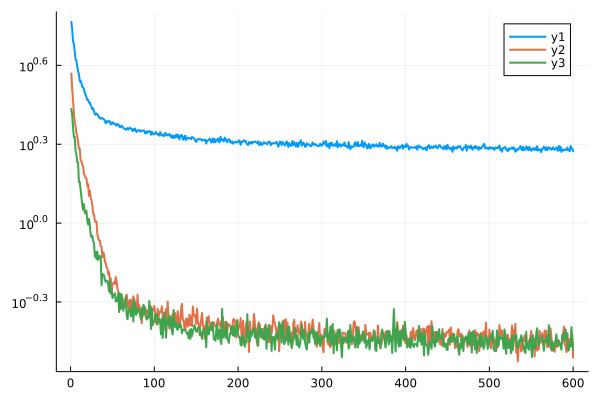

In [19]:
plot(lls[1], lw=2.0, yaxis=:log10)
plot!(lls[2], lw=2.0, yaxis=:log10)
plot!(lls[5], lw=2.0, yaxis=:log10)
#plot!(lls[8], lw=2.0, yaxis=:log10)
#plot!(lls[10], lw=2.0, yaxis=:log10)
#plot!(lls[15], lw=2.0, yaxis=:log10)

In [20]:
buffer = run_selfplay(p, model, 5, 0.0f0)

5-element Vector{Game}:
 Game([9, 8, 6, 1, 2, 4, 3], Vector{Float32}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.9980469, 0.0, 0.0, 0.0, 0.001953125, 0.0, 0.0, 0.0, 0.0], [0.0, 0.96191406, 0.0, 0.0, 0.0, 0.0, 0.038085938, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.9501953, 0.0, 0.0009765625, 0.0, 0.048828125, 0.0, 0.0]], 1)
 Game([7, 9, 1, 6, 3, 4, 5], Vector{Float32}[[0.0, 0.0, 0.0, 0.0, 0.0009765625, 0.0, 0.99902344, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.00390625, 0.0, 0.0, 0.99609375], [0.96972656, 0.0, 0.0, 0.0, 0.0, 0.030273438, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.015625, 0.97558594, 0.0, 0.0078125, 0.0, 0.0, 0.0009765625, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]], 1)
 Game([9, 4, 7, 1, 8], Vector{Float32}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0,

In [21]:
for it in 3:5
    show_state(hist2state(buffer[it].history, 3), 3)
end

------
|×| | |
------
|×| | |
------
|○|○|○|
------
------
|×|○|×|
------
| |×| |
------
|○|○|○|
------
------
|×|○|×|
------
|○|○|○|
------
|×|×|○|
------


シミュレーション数が少ないのか、あんまり強くなってないので、少し改良してみます。(多分サンプル生成の数だったりが足りないのだと思う。(本物よりかなり小さいスケールでシミュレーションをしているので、、))
なんとなく体感として、最後に勝ったかだけでvalue functionを学習すると、相手の手によっての分散が大きすぎる気がするので、run_MCTSで終局までシミュレーションして、その時点でのシミュレーションでの勝率をbufferに記録しておき、それでvalue functionを学習する事にしよう。(自分の論文ではそれでやっていたりする。)

In [22]:
mutable struct Game_new
    history::Vector{Int} #Gameの進行手順を記録
    child_visit::Vector{Vector{Float32}} #π(a|s)の標本を格納
    winner::Int #勝者を格納
    winrate::Vector{Float32} #勝率の標本を格納(本来のalphazeroには存在しない)
end

In [23]:
function evaluate(node::Node, model::Chain, state::Vector{Int})
    if(node.m > 0)
        return node.val_sum/node.m
    end
    l = length(state)
    s0 = zeros(Float32, l,1)
    s0[:,1] = state
    polv = model(s0)
    #println(length(polv))
    v = polv[end,1]

    la = legal_action(state)
    if(isempty(la))
        return v
    else
        pol = [polv[i,1] for i in la]
        policy = softmax(pol)
        for (i,a) in enumerate(la)
            node.child[a] = init_node(0.0f0, policy[i], -node.player)
        end
    end
    return v
end

#勝った瞬間の盤面は相手の手番であるため、勝者を反転させる
function winner2v(winner::Int, player::Int)
    if(winner == player)
        return -1.0f0
        #return 1.0f0
    elseif(winner == -player)
        return 1.0f0
        #return -1.0f0
    else
        return 0.0f0
    end
end

function back_prop!(root::Node, scratch_hist::Vector{Int}, winner::Int)
    node = root
    node.m += 1
    node.val_sum += Float32(winner2v(winner, node.player))
    for a in scratch_hist
        node = node.child[a]
        node.m += 1
        node.val_sum += Float32(winner2v(winner, node.player))
    end
end

back_prop! (generic function with 3 methods)

In [24]:
#MCTSの実行(シミュレーションを実行し、次の1手を決める)
function run_mcts(p::AZ_parm, model::Chain, game::Game_new, n_ratio::Float32)
    root = init_node(0.0f0, 1.0f0, (-1)^(length(game.history)))
    
    state = hist2state(game.history, p.l)
    v0 = evaluate(root, model, state)
    add_exploration_noise!(p, root, n_ratio)
    
    for i in 1:p.num_simulation
        node = root
        scratch_hist = deepcopy(game.history)
        state = hist2state(scratch_hist, p.l)
        additional_hist = Int[]
        #serach_path::Vector{Node} = [node]
        while(true)
            if(isempty(node.child)||is_finish(state, p.fvs))
                break
            else
                action, node = select_child(p, node)
                push!(scratch_hist, action)
                push!(additional_hist, action)
                state = hist2state(scratch_hist, p.l)
                v = evaluate(node, model, state)
            end
        end
        
        #back_prop!(serach_path, v, (-1)^(length(scratch_hist)))
        #back_prop!(root, additional_hist, v)
        winner = whowin(state, p.fvs)
        back_prop!(root, additional_hist, winner)
    end
    #これは本来のalphazeroには存在しない
    #winrate = root.val_sum/root.m
    return select_action(root), root
end

#MCTSを使って終局までゲームをプレイ
function play_game_new(p::AZ_parm, model::Chain, n_ratio::Float32)
    game = Game_new([], [], 0, [])
    while(true)
        action, root = run_mcts(p, model, game, n_ratio)
        push!(game.history, action)
        push!(game.winrate, root.val_sum/root.m)
        
        visits = zeros(Float32, p.l^2)
        for a in keys(root.child)
            visits[a] = (root.child[a]).m
        end
        
        push!(game.child_visit, visits./sum(visits))
        #println(visits)
        state = hist2state(game.history, p.l)
        if(is_finish(state, p.fvs))
            game.winner = whowin(state, p.fvs)
            break
        end
    end
    return game
end

function run_selfplay_new(p::AZ_parm, model::Chain, N::Int, n_ratio::Float32)
    buffer::Vector{Game_new} = []
    for i in 1:N
        game = play_game_new(p, model, n_ratio)
        push!(buffer, game)
    end
    return buffer
end

run_selfplay_new (generic function with 1 method)

In [25]:
function sample_batch(p::AZ_parm, buffer::Vector{Game_new}, batch_size::Int)
    image_batch = zeros(Int, p.l^2, batch_size)
    target_batch = zeros(Float32, p.l^2+1, batch_size)
    lengths = [length(game.history) for game in buffer]
    weights = lengths./sum(lengths)
    sample_games = sample(1:length(buffer), ProbabilityWeights(weights), batch_size)
    for (i,gi) in enumerate(sample_games)
        g = buffer[gi]
        sample_turn = rand(1:length(g.history))
        image_batch[:,i] = hist2state(g.history[1:sample_turn], p.l)
        target_batch[:,i] = vcat(g.child_visit[sample_turn], Float32(g.winrate[sample_turn]))
    end
    return image_batch, target_batch
end
function train_model!(p::AZ_parm, buffer::Vector{Game_new}, model::Chain, batch_size::Int, opt)
    im_batch, tg_batch = sample_batch(p, buffer, batch_size)
    val, grads = Flux.withgradient(Flux.params(model)) do 
        loss(model, im_batch, tg_batch)
    end
    Flux.Optimise.update!(opt, Flux.params(model), grads)
    return val
end

train_model! (generic function with 2 methods)

In [26]:
function alpha_zero_new(p::AZ_parm, n_itr::Int)
    #深さ、幅をケチるとあんまり強くならない。本物は幅1024の深さ19ぐらい。今回はcpuで走らせるのでこんくらいにしておく。
    width = 64
    depth = 4
    model = Chain(Dense(zeros(Float32, p.l^2+1, p.l^2))) #最初は完全にランダム
    lls = []
    n_ratio = 1.2f0
    γ = 0.8f0
    for i in 1:n_itr
        n_ratio = n_ratio * γ^(n_itr-1)
        @time buffer = run_selfplay_new(p, model, 200, n_ratio)
        #模擬的なalpha zeroのNN。本物はもっと深いしCNNも使っている。
        if(i==1)
            model = Chain(Dense(p.l^2, width), (Flux.Parallel(+,Chain(BatchNorm(width),Dense(width, width, relu), BatchNorm(width),Dense(width, width, relu)), identity) for i in 1:depth)...,  Flux.Parallel(vcat,Chain((Flux.Parallel(+,Chain(BatchNorm(width), Dense(width, width, relu)), identity) for i in 1:depth)..., Dense(width, p.l^2, tanh4)), Chain((Flux.Parallel(+,Chain(BatchNorm(width), Dense(width, width, relu)), identity) for i in 1:depth)..., Dense(width, 1, tanh))))
        end
        opt = Flux.Optimiser(WeightDecay(1f-6), Adam(1f-3))
        loss_hist = Float32[]
        @time for j in 1:600
            val = train_model!(p, buffer, model, 1000, opt)
            #println(val)
            push!(loss_hist, val)
        end
        push!(lls, loss_hist)
    end
    return model, lls
end

alpha_zero_new (generic function with 1 method)

In [27]:
model, lls = alpha_zero_new(p, 5)

  7.858913 seconds (116.03 M allocations: 10.568 GiB, 25.51% gc time, 1.16% compilation time)
 49.141748 seconds (104.06 M allocations: 145.620 GiB, 38.74% gc time, 0.57% compilation time)
 33.052635 seconds (372.66 M allocations: 50.739 GiB, 18.95% gc time, 0.30% compilation time)
 48.178613 seconds (103.52 M allocations: 145.593 GiB, 37.97% gc time)
 32.063757 seconds (355.40 M allocations: 48.303 GiB, 21.32% gc time)
 43.453556 seconds (103.52 M allocations: 145.593 GiB, 38.81% gc time)
 28.818733 seconds (322.10 M allocations: 43.356 GiB, 21.47% gc time)
 44.498282 seconds (103.52 M allocations: 145.593 GiB, 39.75% gc time)
 29.584683 seconds (339.36 M allocations: 46.024 GiB, 19.17% gc time)
 42.726104 seconds (103.52 M allocations: 145.592 GiB, 38.80% gc time)


(Chain(Dense(9 => 64), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu), BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu), BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu), BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu), BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(vcat, Chain(Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Dense(64 => 9, tanh4)), Chain(Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNorm(64), Dense(64 => 64, relu)), identity), Parallel(+, Chain(BatchNor

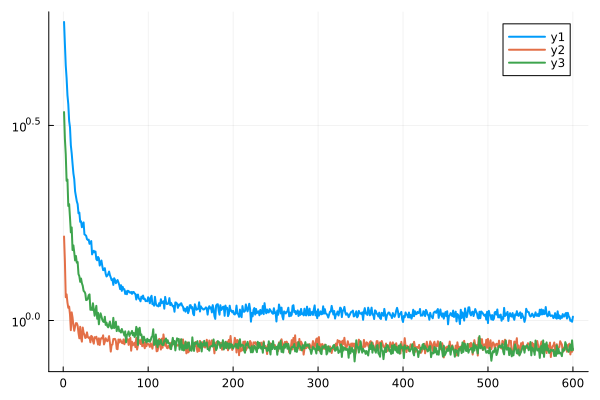

In [28]:
plot(lls[1], lw=2.0, yaxis=:log10)
plot!(lls[2], lw=2.0, yaxis=:log10)
plot!(lls[5], lw=2.0, yaxis=:log10)
#plot!(lls[8], lw=2.0, yaxis=:log10)
#plot!(lls[10], lw=2.0, yaxis=:log10)
#plot!(lls[15], lw=2.0, yaxis=:log10)

In [29]:
buffer = run_selfplay_new(p, model, 5, 0.0f0)

5-element Vector{Game_new}:
 Game_new([5, 1, 7, 8, 3], Vector{Float32}[[0.0068359375, 0.022460938, 0.059570312, 0.0029296875, 0.7998047, 0.0009765625, 0.040039062, 0.0, 0.06738281], [0.5078125, 0.0546875, 0.27246094, 0.0078125, 0.0, 0.01171875, 0.10253906, 0.001953125, 0.041015625], [0.0, 0.0234375, 0.016601562, 0.013671875, 0.0, 0.0068359375, 0.89941406, 0.0078125, 0.032226562], [0.0, 0.359375, 0.13671875, 0.064453125, 0.0, 0.038085938, 0.0, 0.36621094, 0.03515625], [0.0, 0.0009765625, 0.7792969, 0.17285156, 0.0, 0.0, 0.0, 0.0, 0.046875]], 1, Float32[-0.43359375, 0.50683594, -0.8496094, 0.8798828, -0.8183594])
 Game_new([3, 5, 1, 2, 8, 6, 4, 7, 9], Vector{Float32}[[0.0126953125, 0.0009765625, 0.85253906, 0.0009765625, 0.040039062, 0.0, 0.015625, 0.0, 0.07714844], [0.17480469, 0.056640625, 0.0, 0.0009765625, 0.5810547, 0.021484375, 0.09375, 0.0009765625, 0.0703125], [0.5341797, 0.23828125, 0.0, 0.0029296875, 0.0, 0.041015625, 0.15917969, 0.01953125, 0.0048828125], [0.0, 0.9296875, 0.0,

毎回引き分けになっているし、手順を見ていると順当な手を打っているので、学習がちゃんと出来ているようだ。

In [30]:
for it in 2:5
    show_state(hist2state(buffer[it].history, 3), 3)
end

------
|○|×|○|
------
|○|×|×|
------
|×|○|○|
------
------
|×|○|○|
------
|○|○|×|
------
|×|×|○|
------
------
|○|×|○|
------
|×|×|○|
------
|○|○|×|
------
------
|○|×|×|
------
|×|○|○|
------
|○|○|×|
------


## さらに勉強する人へ

一応このTutorialで強化学習の基本的な知識とその実装を2017年のAlphaZeroまで学ぶことが出来たかと思います。今回取り上げなかったテクニックも幾つかあるのですが、例えばRainbowというDQNのテクニック詰め合わせの手法(論文)があるので、それを読んで、出てくる手法を勉強すれば、さらに深く学べるかと思います。

それ以降の論文も、今回のTutorialとRainbowの論文で、論文を読むための最低限の知識はついていると思うので、自分である程度気持ちよく読んでいけるかと思います。

最後まで読んでくれた読者の方々ありがとうございました！良いお年を！